In [1]:
import numpy as np
import pandas as pd  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import mean_squared_error, mean_absolute_error , mean_absolute_percentage_error
import matplotlib.pyplot as plt


Part 1

In [2]:
# Load dataset
train_df = pd.read_csv('/Users/hanyfaltaos/Downloads/Neuoral 24-25/train.csv')

# Check for missing values
print("Missing values per column:\n", train_df.isnull().sum())

# Handle missing values
if train_df.isnull().sum().sum() > 0:  # Check if there are any missing values
    # Fill missing values with column median
    train_df = train_df.fillna(train_df.median())
    print("Missing values handled by imputation (median substitution).")
else:
    print("No missing values found.")

# Define input (X) and target (y) features
input_features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
X = train_df[input_features]
y = train_df['MedHouseVal']

# Normalize input features for neural network training
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Normalize the target feature using MinMaxScaler
y_scaler = MinMaxScaler()
y_normalized = y_scaler.fit_transform(y.values.reshape(-1, 1))

# Split data into 80% for training/validation and 20% for testing
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_normalized, y_normalized, test_size=0.2, random_state=42, shuffle=True
)

# Further split training/validation data into 75% training and 25% validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, shuffle=True
)

# Print the number of records in each set
print(f"Training Data: {len(X_train)} records")
print(f"Validation Data: {len(X_val)} records")
print(f"Testing Data: {len(X_test)} records")

print("Data preprocessing and splitting completed!")

Missing values per column:
 id             0
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64
No missing values found.
Training Data: 22281 records
Validation Data: 7428 records
Testing Data: 7428 records
Data preprocessing and splitting completed!


Part 2

Epoch 1/50, Training Loss: 0.11639080071031098, Validation Loss: 0.11511571330803953
Epoch 2/50, Training Loss: 0.10417103922522475, Validation Loss: 0.10298687843306156
Epoch 3/50, Training Loss: 0.09225276471977906, Validation Loss: 0.09112666874480231
Epoch 4/50, Training Loss: 0.08148875280318736, Validation Loss: 0.08037573093980327
Epoch 5/50, Training Loss: 0.07283995276596122, Validation Loss: 0.07169340391776068
Epoch 6/50, Training Loss: 0.06646723478356825, Validation Loss: 0.06525085119918449
Epoch 7/50, Training Loss: 0.062379887078299584, Validation Loss: 0.06107816939840353
Epoch 8/50, Training Loss: 0.059983316135298184, Validation Loss: 0.05859840110138303
Epoch 9/50, Training Loss: 0.058672762115869186, Validation Loss: 0.05721691070539516
Epoch 10/50, Training Loss: 0.05798829650754675, Validation Loss: 0.05647680974957698
Epoch 11/50, Training Loss: 0.05763061324313709, Validation Loss: 0.056076368053126144
Epoch 12/50, Training Loss: 0.057456576525364705, Validatio

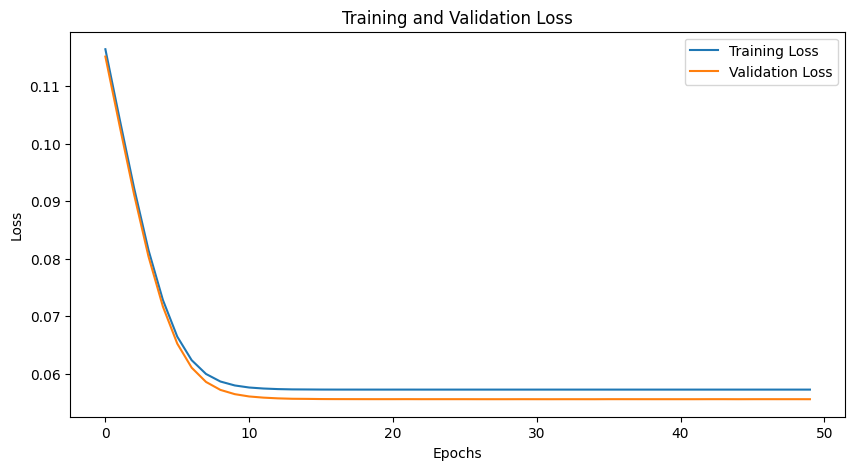

In [3]:
# Part 2: Neural Network Implementation from Scratch

class NeuralNet:
    def __init__(self, layers, epochs, learning_rate, momentum, activation='relu', val_split=0.2):
        self.L = len(layers)  # Number of layers
        self.n = layers  # Number of units in each layer
        self.epochs = epochs
        self.lr = learning_rate
        self.momentum = momentum
        self.activation_name = activation
        self.val_split = val_split

        # Initialize weights and thresholds using Xavier initialization
        self.w = [None] + [np.random.randn(self.n[l], self.n[l - 1]) * np.sqrt(2 / (self.n[l] + self.n[l - 1])) for l in range(1, self.L)]
        self.theta = [None] + [np.random.randn(self.n[l]) * np.sqrt(2 / self.n[l]) for l in range(1, self.L)]

        # Initialize previous weight changes for momentum
        self.d_w_prev = [None] + [np.zeros_like(self.w[l]) for l in range(1, self.L)]
        self.d_theta_prev = [None] + [np.zeros_like(self.theta[l]) for l in range(1, self.L)]

        # Initialize activations, fields, and deltas
        self.xi = [None] * self.L  # Array to hold activations for each layer
        self.h = [None] * self.L  # Array to hold the weighted sums before activation
        self.delta = [None] * self.L  # Array to hold error propagation terms for each layer

    def activation(self, x):
        if self.activation_name == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation_name == 'relu':
            return np.maximum(0, x)
        elif self.activation_name == 'tanh':
            return np.tanh(x)
        elif self.activation_name == 'linear':
            return x

    def activation_derivative(self, x):
        if self.activation_name == 'sigmoid':
            return x * (1 - x)
        elif self.activation_name == 'relu':
            return np.where(x > 0, 1, 0)
        elif self.activation_name == 'tanh':
            return 1 - np.tanh(x) ** 2
        elif self.activation_name == 'linear':
            return np.ones_like(x)

    def feed_forward(self, x):
        x = np.array(x, dtype=float)  # Ensure input is a numpy array of floats
        self.xi[0] = x
        for l in range(1, self.L):
            self.h[l] = np.dot(self.w[l], self.xi[l - 1]) - self.theta[l]
            self.xi[l] = self.activation(self.h[l])
        return self.xi

    def back_propagate(self, y):
        # Calculate deltas and update weights/thresholds
        self.delta[-1] = self.activation_derivative(self.xi[-1]) * (self.xi[-1] - y)
        
        # Back-propagate delta to hidden layers
        for l in reversed(range(1, self.L - 1)):
            self.delta[l] = self.activation_derivative(self.xi[l]) * np.dot(self.w[l + 1].T, self.delta[l + 1])

        # Update weights and thresholds using deltas
        for l in range(1, self.L):
            d_w = -self.lr * np.outer(self.delta[l], self.xi[l - 1]) + self.momentum * self.d_w_prev[l]
            d_theta = self.lr * self.delta[l] + self.momentum * self.d_theta_prev[l]
            self.w[l] += d_w
            self.theta[l] += d_theta
            self.d_w_prev[l], self.d_theta_prev[l] = d_w, d_theta

    def fit(self, X, y, X_val=None, y_val=None):
        train_loss = []
        val_loss = []

        for epoch in range(self.epochs):
            for i in range(len(X)):
                # Choose a random pattern for online training
                idx = np.random.randint(0, len(X))
                x_mu, y_mu = np.array(X)[idx], np.array(y)[idx]

                # Feed-forward and back-propagate
                self.feed_forward(x_mu)
                self.back_propagate(y_mu)

            # Calculate training loss for the current epoch
            train_predictions = self.predict(np.array(X, dtype=float))
            train_loss.append(np.mean((train_predictions - np.array(y, dtype=float)) ** 2))

            # Calculate validation loss if validation data is provided
            if X_val is not None and y_val is not None:
                val_predictions = self.predict(np.array(X_val, dtype=float))
                val_loss.append(np.mean((val_predictions - np.array(y_val, dtype=float)) ** 2))

            # Print loss for each epoch to monitor training
            print(f"Epoch {epoch + 1}/{self.epochs}, Training Loss: {train_loss[-1]}, Validation Loss: {val_loss[-1] if val_loss else 'N/A'}")

        return train_loss, val_loss

    def predict(self, X):
        X = np.array(X, dtype=float)  # Ensure input is a numpy array of floats
        predictions = []
        for x in X:
            self.feed_forward(x)
            predictions.append(self.xi[-1])
        return np.array(predictions)

    def loss_epochs(self, X_train, y_train, X_val, y_val):
        train_loss = []
        val_loss = []
        for epoch in range(self.epochs):
            train_predictions = self.predict(X_train)
            val_predictions = self.predict(X_val)

            train_loss.append(np.mean((train_predictions - y_train) ** 2))
            val_loss.append(np.mean((val_predictions - y_val) ** 2))
        return train_loss, val_loss

# Plotting Training and Validation Loss
def plot_loss(train_loss, val_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Training Loss')
    if val_loss:
        plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# Normalize Input Features for Training, Validation, and Testing
X_train_scaled = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_val_scaled = (X_val - X_val.min()) / (X_val.max() - X_val.min())
X_test_scaled = (X_test - X_test.min()) / (X_test.max() - X_test.min())

# Initialize and Train the Neural Network
nn_test = NeuralNet(
    layers=[8, 9, 5, 1],  # Architecture: 8 input features, 2 hidden layers, 1 output
    epochs=50,  # Number of epochs
    learning_rate=0.00001,  # Learning rate
    momentum=0.9,  # Momentum term
    activation='sigmoid',  # Activation function
    val_split=0.2  # Validation split is handled externally
)

train_loss, val_loss = nn_test.fit(
    X_train_scaled, y_train, X_val_scaled, y_val
)

# Evaluate on Test Data
test_predictions = nn_test.predict(X_test_scaled)
test_loss = np.mean((test_predictions - y_test) ** 2)
print(f"Test Loss: {test_loss}")

# Plot Training and Validation Loss
plot_loss(train_loss, val_loss)


Part 3.1

Evaluating Set 1 - Layers: [8, 9, 1], Learning Rate: 0.0001, Momentum: 0.5, Activation: sigmoid
Epoch 1/50, Training Loss: 0.05666920658947517, Validation Loss: 0.059211767986712044
Epoch 2/50, Training Loss: 0.056611033272778444, Validation Loss: 0.05919879738506054
Epoch 3/50, Training Loss: 0.05660560937491231, Validation Loss: 0.05919995812169434
Epoch 4/50, Training Loss: 0.05659157794364058, Validation Loss: 0.059214890038961764
Epoch 5/50, Training Loss: 0.05659065589637754, Validation Loss: 0.059218801804976996
Epoch 6/50, Training Loss: 0.056590991148122174, Validation Loss: 0.05921627426311511
Epoch 7/50, Training Loss: 0.0565906657988083, Validation Loss: 0.05923393231880752
Epoch 8/50, Training Loss: 0.05658995003934891, Validation Loss: 0.05922638641182164
Epoch 9/50, Training Loss: 0.05658987235983141, Validation Loss: 0.05922269835711435
Epoch 10/50, Training Loss: 0.056590890646294335, Validation Loss: 0.0592146136159782
Epoch 11/50, Training Loss: 0.05659020209545156, 

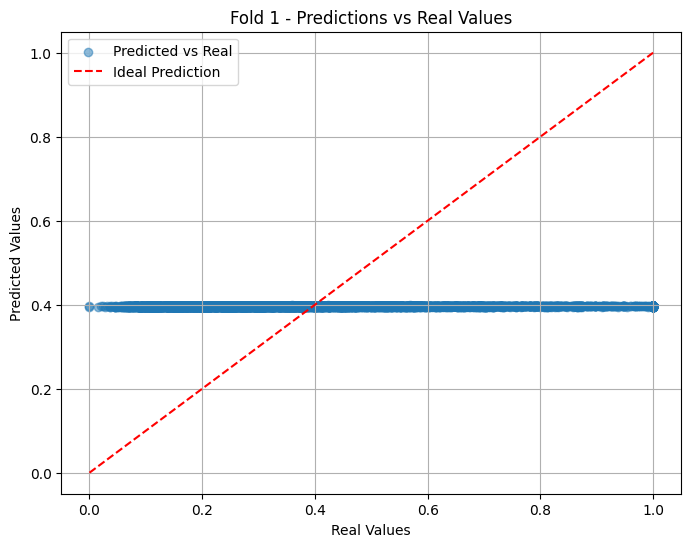

Epoch 1/50, Training Loss: 0.1282487035010752, Validation Loss: 0.12921113191496802
Epoch 2/50, Training Loss: 0.07728072098534045, Validation Loss: 0.07728387571921208
Epoch 3/50, Training Loss: 0.062119442977758337, Validation Loss: 0.06157002501680593
Epoch 4/50, Training Loss: 0.058533441960117755, Validation Loss: 0.057717771166857265
Epoch 5/50, Training Loss: 0.05763815262005622, Validation Loss: 0.05668715458421711
Epoch 6/50, Training Loss: 0.057429076488760715, Validation Loss: 0.056412535956496604
Epoch 7/50, Training Loss: 0.05737256107122386, Validation Loss: 0.05631472750985426
Epoch 8/50, Training Loss: 0.057369543626415276, Validation Loss: 0.05630671293750823
Epoch 9/50, Training Loss: 0.05736711140087561, Validation Loss: 0.05629838568533875
Epoch 10/50, Training Loss: 0.057365813278713804, Validation Loss: 0.05628678359565797
Epoch 11/50, Training Loss: 0.05736563165728712, Validation Loss: 0.0562893016674961
Epoch 12/50, Training Loss: 0.05737052482727428, Validatio

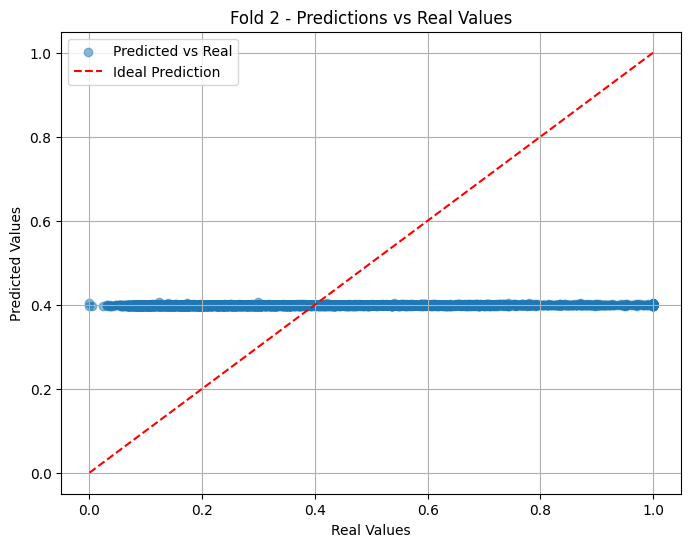

Epoch 1/50, Training Loss: 0.11131447829772251, Validation Loss: 0.11133915960528233
Epoch 2/50, Training Loss: 0.07172142296852695, Validation Loss: 0.07111850760342993
Epoch 3/50, Training Loss: 0.06119696190638344, Validation Loss: 0.06026559911831765
Epoch 4/50, Training Loss: 0.058637612897775776, Validation Loss: 0.05754877926718091
Epoch 5/50, Training Loss: 0.05789082262907045, Validation Loss: 0.0567104773789153
Epoch 6/50, Training Loss: 0.05773483336897012, Validation Loss: 0.05651429526074838
Epoch 7/50, Training Loss: 0.057711739860975095, Validation Loss: 0.0564809254026701
Epoch 8/50, Training Loss: 0.05768923388201721, Validation Loss: 0.05644211114787903
Epoch 9/50, Training Loss: 0.057683957807095704, Validation Loss: 0.056426882222524434
Epoch 10/50, Training Loss: 0.05768615718016446, Validation Loss: 0.05641711411037922
Epoch 11/50, Training Loss: 0.057683633842239665, Validation Loss: 0.05642570432476845
Epoch 12/50, Training Loss: 0.05768351002650178, Validation 

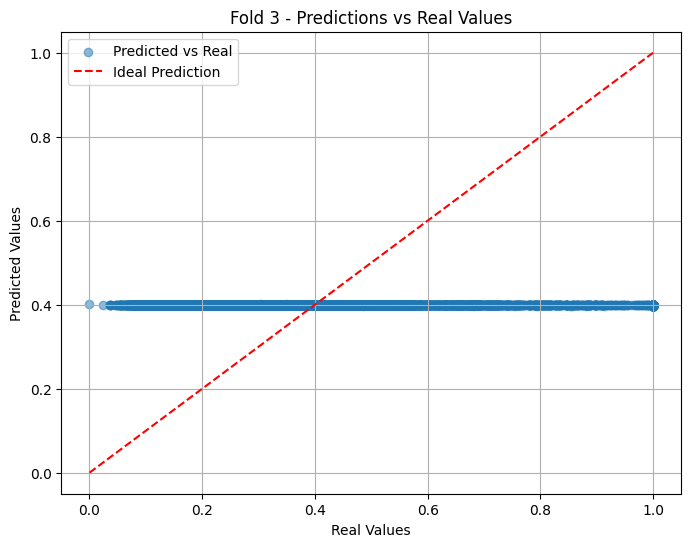

Epoch 1/50, Training Loss: 0.06466622198723665, Validation Loss: 0.06466554454686149
Epoch 2/50, Training Loss: 0.05969712432722246, Validation Loss: 0.0595874332363918
Epoch 3/50, Training Loss: 0.05796330522952108, Validation Loss: 0.05778318009465376
Epoch 4/50, Training Loss: 0.05756001032536993, Validation Loss: 0.05734816495335259
Epoch 5/50, Training Loss: 0.05743309744475387, Validation Loss: 0.05720280334175645
Epoch 6/50, Training Loss: 0.05739201748330472, Validation Loss: 0.057149205510008454
Epoch 7/50, Training Loss: 0.05738667877107881, Validation Loss: 0.057140056908541625
Epoch 8/50, Training Loss: 0.05738470886398442, Validation Loss: 0.05713421443128953
Epoch 9/50, Training Loss: 0.05738525616259636, Validation Loss: 0.057132265511136794
Epoch 10/50, Training Loss: 0.05738607465694182, Validation Loss: 0.0571390708732093
Epoch 11/50, Training Loss: 0.05738451685150307, Validation Loss: 0.05713305702563914
Epoch 12/50, Training Loss: 0.05738539837739254, Validation Lo

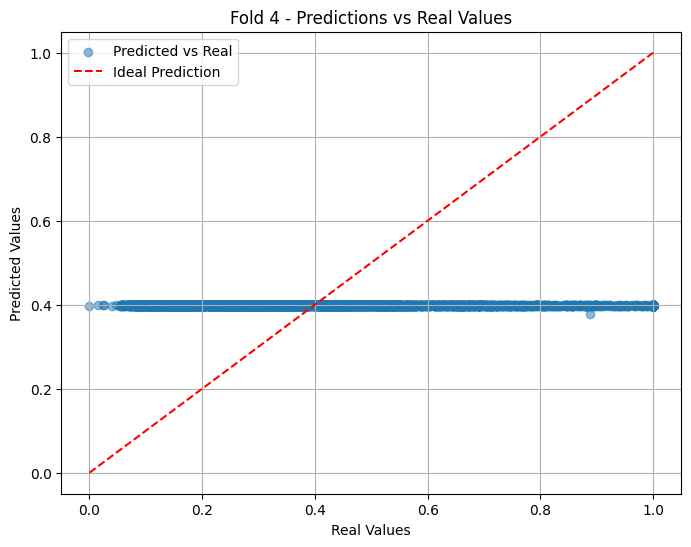

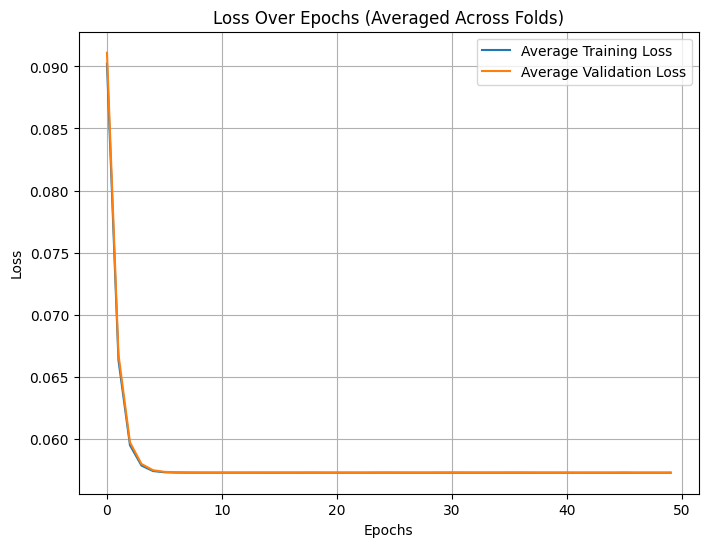

Evaluating Set 2 - Layers: [8, 12, 1], Learning Rate: 0.01, Momentum: 0.9, Activation: relu
Epoch 1/50, Training Loss: 0.05666938274803246, Validation Loss: 0.05961302839936431
Epoch 2/50, Training Loss: 0.05575393294748067, Validation Loss: 0.058409348599351076
Epoch 3/50, Training Loss: 0.05624895592777578, Validation Loss: 0.059302602758333836
Epoch 4/50, Training Loss: 0.062337862594491526, Validation Loss: 0.06409700217354702
Epoch 5/50, Training Loss: 0.057274375269321005, Validation Loss: 0.060216277477569524
Epoch 6/50, Training Loss: 0.05749028206051791, Validation Loss: 0.05983079766926607
Epoch 7/50, Training Loss: 0.059190905382530856, Validation Loss: 0.06130994764237987
Epoch 8/50, Training Loss: 0.05202056234350032, Validation Loss: 0.05497922264238279
Epoch 9/50, Training Loss: 0.056649618817100275, Validation Loss: 0.05923363501809763
Epoch 10/50, Training Loss: 0.04785772575118202, Validation Loss: 0.050697372209491824
Epoch 11/50, Training Loss: 0.040935334603901696,

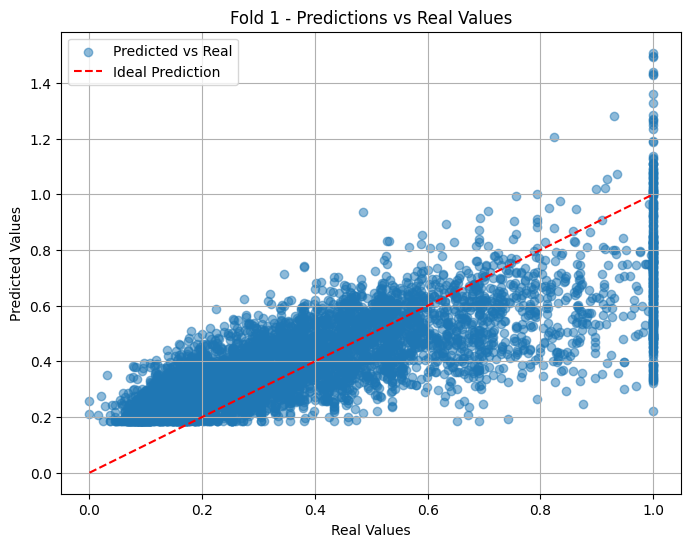

Epoch 1/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 2/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 3/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 4/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 5/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 6/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 7/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 8/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 9/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 10/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 11/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 12/50, Training Loss: 0.2164758905139149, Validation Loss: 0.2123134

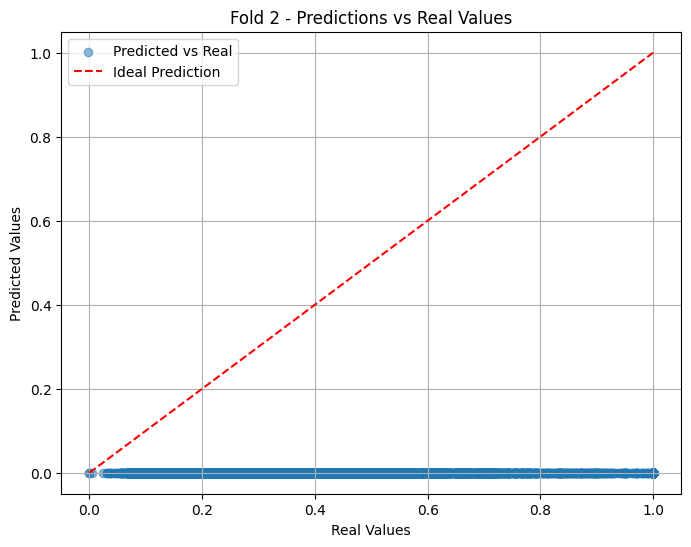

Epoch 1/50, Training Loss: 0.056907319287596576, Validation Loss: 0.055442202113032996
Epoch 2/50, Training Loss: 0.05821931678969742, Validation Loss: 0.05718924219976083
Epoch 3/50, Training Loss: 0.05470404771519156, Validation Loss: 0.05295138764248964
Epoch 4/50, Training Loss: 0.06358492106312252, Validation Loss: 0.061181020611218766
Epoch 5/50, Training Loss: 0.04252400279989436, Validation Loss: 0.04063336808655576
Epoch 6/50, Training Loss: 0.038065540813565855, Validation Loss: 0.036152393309025706
Epoch 7/50, Training Loss: 0.034242748828149885, Validation Loss: 0.032576673082291535
Epoch 8/50, Training Loss: 0.03408783348719823, Validation Loss: 0.03262591656356279
Epoch 9/50, Training Loss: 0.040421536789282786, Validation Loss: 0.038027613474440614
Epoch 10/50, Training Loss: 0.0303536767937154, Validation Loss: 0.0288413420714877
Epoch 11/50, Training Loss: 0.029462343674307827, Validation Loss: 0.02780417595860838
Epoch 12/50, Training Loss: 0.03239508842716114, Valida

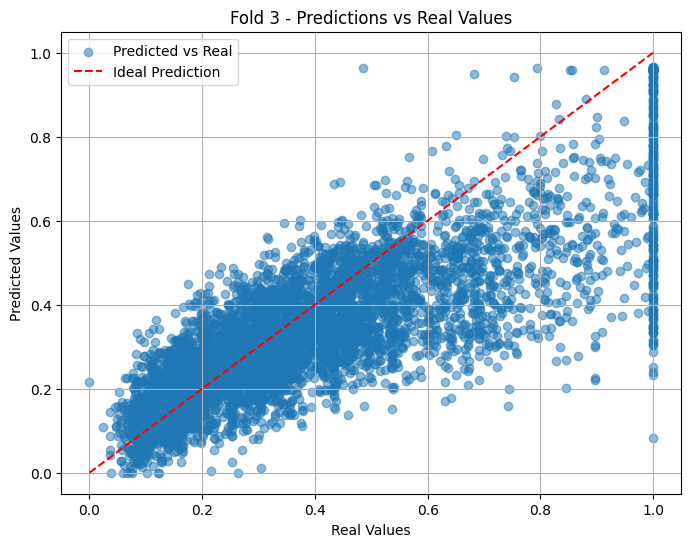

Epoch 1/50, Training Loss: 0.05896259288532478, Validation Loss: 0.05856462206973859
Epoch 2/50, Training Loss: 0.06511439998679415, Validation Loss: 0.06459434258789949
Epoch 3/50, Training Loss: 0.05748767285969625, Validation Loss: 0.057153264827719034
Epoch 4/50, Training Loss: 0.06282676219444538, Validation Loss: 0.0628197675167092
Epoch 5/50, Training Loss: 0.05752296141006234, Validation Loss: 0.05724693484797329
Epoch 6/50, Training Loss: 0.057526340173006486, Validation Loss: 0.05732982437187363
Epoch 7/50, Training Loss: 0.05828812877897097, Validation Loss: 0.05796163945893218
Epoch 8/50, Training Loss: 0.061100804866243086, Validation Loss: 0.06107054566417967
Epoch 9/50, Training Loss: 0.05746365602177983, Validation Loss: 0.05720577142485023
Epoch 10/50, Training Loss: 0.06418235448921825, Validation Loss: 0.06420716944610451
Epoch 11/50, Training Loss: 0.05863345209274546, Validation Loss: 0.05830431242717313
Epoch 12/50, Training Loss: 0.05761241953524369, Validation L

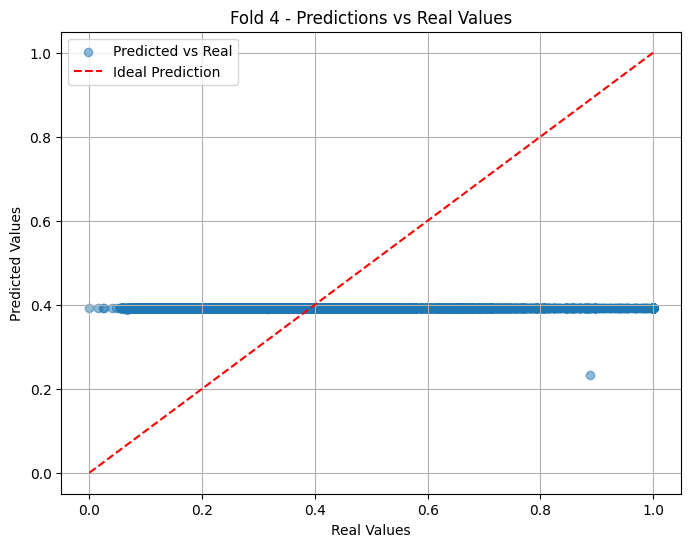

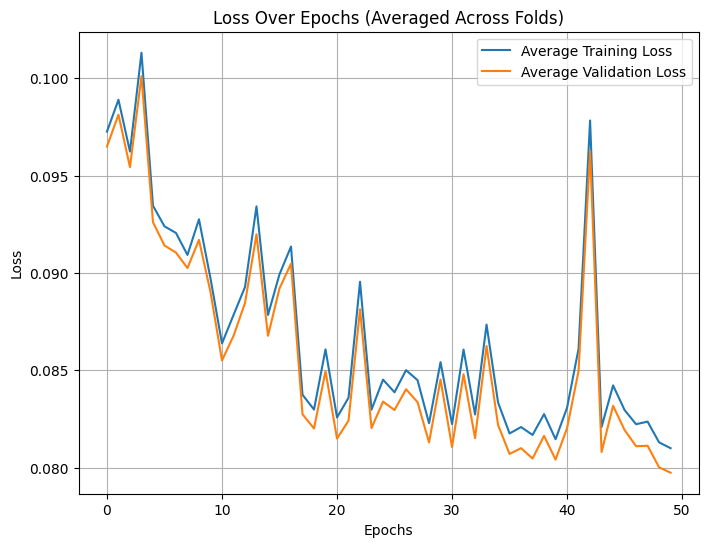

Evaluating Set 3 - Layers: [8, 10, 5, 1], Learning Rate: 0.01, Momentum: 0.9, Activation: tanh
Epoch 1/50, Training Loss: 0.06378888674387398, Validation Loss: 0.0673131256060236
Epoch 2/50, Training Loss: 0.05815366407567032, Validation Loss: 0.061215758835959345
Epoch 3/50, Training Loss: 0.05830213189972374, Validation Loss: 0.06044966159520618
Epoch 4/50, Training Loss: 0.05799077419832631, Validation Loss: 0.0601167500515891
Epoch 5/50, Training Loss: 0.05770932288199393, Validation Loss: 0.05965253815600522
Epoch 6/50, Training Loss: 0.051905007007485106, Validation Loss: 0.054686450472188286
Epoch 7/50, Training Loss: 0.0449618665076634, Validation Loss: 0.047106259331516555
Epoch 8/50, Training Loss: 0.04473118689806334, Validation Loss: 0.04742867474193132
Epoch 9/50, Training Loss: 0.05101100419421775, Validation Loss: 0.05208447040652216
Epoch 10/50, Training Loss: 0.03761047735012533, Validation Loss: 0.038999004512713556
Epoch 11/50, Training Loss: 0.03297966982177938, Val

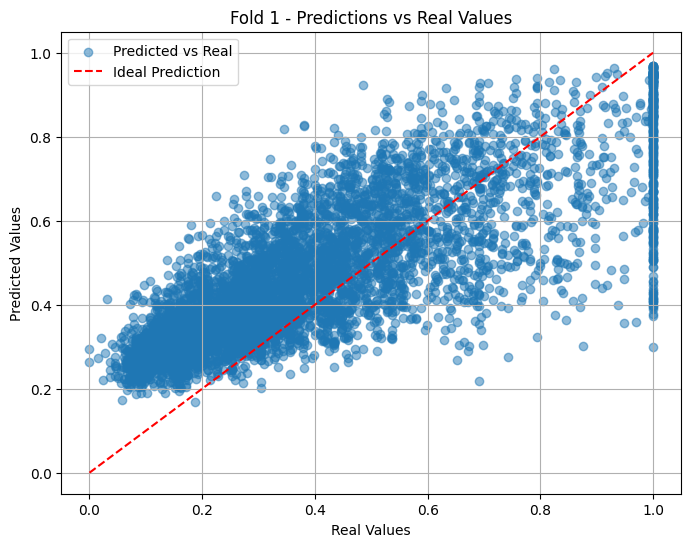

Epoch 1/50, Training Loss: 0.05700846042389116, Validation Loss: 0.056190217613010324
Epoch 2/50, Training Loss: 0.05580308953915846, Validation Loss: 0.05459057268710193
Epoch 3/50, Training Loss: 0.07817795894059937, Validation Loss: 0.07659390457304949
Epoch 4/50, Training Loss: 0.05039443373782944, Validation Loss: 0.04969773741253666
Epoch 5/50, Training Loss: 0.06524401345287334, Validation Loss: 0.06469434747267104
Epoch 6/50, Training Loss: 0.03576719090869222, Validation Loss: 0.035750724214083075
Epoch 7/50, Training Loss: 0.03760140614034701, Validation Loss: 0.037647139562281697
Epoch 8/50, Training Loss: 0.031824872090191615, Validation Loss: 0.03189706605366084
Epoch 9/50, Training Loss: 0.03062920649005422, Validation Loss: 0.03082439504987083
Epoch 10/50, Training Loss: 0.03650077184939913, Validation Loss: 0.03708437895467618
Epoch 11/50, Training Loss: 0.028901995953143626, Validation Loss: 0.029111134410782703
Epoch 12/50, Training Loss: 0.03212473481266095, Validati

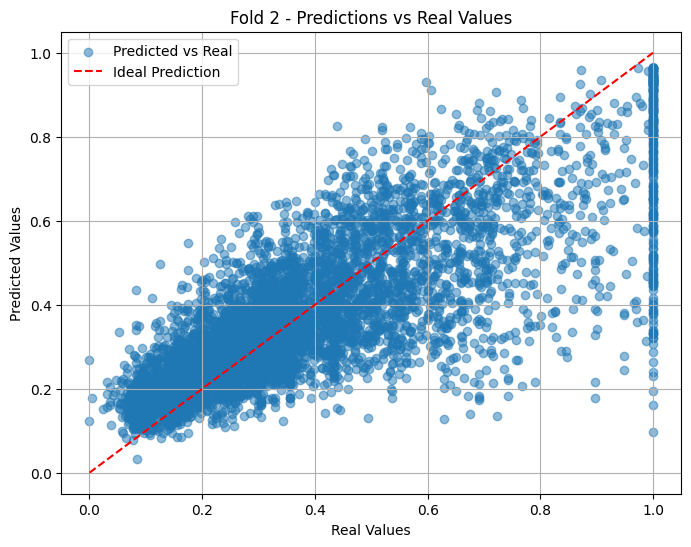

Epoch 1/50, Training Loss: 0.05981001744070697, Validation Loss: 0.05825497735394805
Epoch 2/50, Training Loss: 0.057517206992403654, Validation Loss: 0.056388681073510326
Epoch 3/50, Training Loss: 0.05635917377735629, Validation Loss: 0.05518566328007302
Epoch 4/50, Training Loss: 0.05511595525886895, Validation Loss: 0.053457480846238734
Epoch 5/50, Training Loss: 0.04648752078107318, Validation Loss: 0.04504411672188177
Epoch 6/50, Training Loss: 0.04221985142162117, Validation Loss: 0.040582385826952005
Epoch 7/50, Training Loss: 0.03749229254168794, Validation Loss: 0.03596918631864943
Epoch 8/50, Training Loss: 0.0353187056048058, Validation Loss: 0.03374962792998888
Epoch 9/50, Training Loss: 0.03390541786616882, Validation Loss: 0.032382549758283634
Epoch 10/50, Training Loss: 0.03329429511074195, Validation Loss: 0.03129323002627886
Epoch 11/50, Training Loss: 0.03160914568089183, Validation Loss: 0.03008993045861091
Epoch 12/50, Training Loss: 0.031078997038155413, Validatio

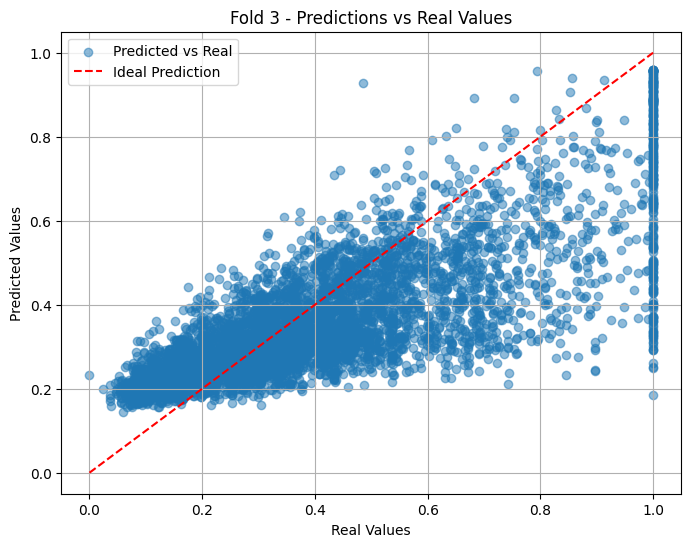

Epoch 1/50, Training Loss: 0.057854339315137795, Validation Loss: 0.057516305045094904
Epoch 2/50, Training Loss: 0.06199782293522731, Validation Loss: 0.06153062030912571
Epoch 3/50, Training Loss: 0.056687975094568036, Validation Loss: 0.05634797600825593
Epoch 4/50, Training Loss: 0.0692963937086706, Validation Loss: 0.06870098137001027
Epoch 5/50, Training Loss: 0.07428996162099365, Validation Loss: 0.07369780181676755
Epoch 6/50, Training Loss: 0.040942457610040686, Validation Loss: 0.04071333653632727
Epoch 7/50, Training Loss: 0.04213351103223806, Validation Loss: 0.041904897116448715
Epoch 8/50, Training Loss: 0.03520450986847934, Validation Loss: 0.03494276815029978
Epoch 9/50, Training Loss: 0.03532528388058087, Validation Loss: 0.03513660587101018
Epoch 10/50, Training Loss: 0.03333311399125159, Validation Loss: 0.03310569556541896
Epoch 11/50, Training Loss: 0.030422449735272746, Validation Loss: 0.030133637814352077
Epoch 12/50, Training Loss: 0.03245645729007678, Validati

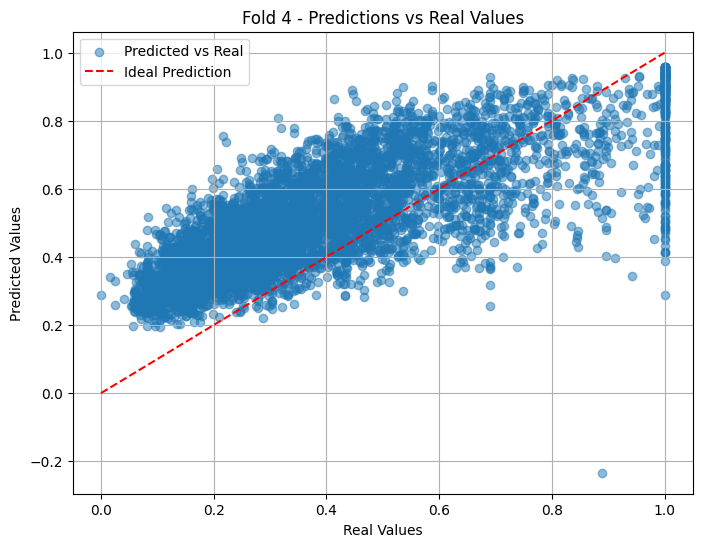

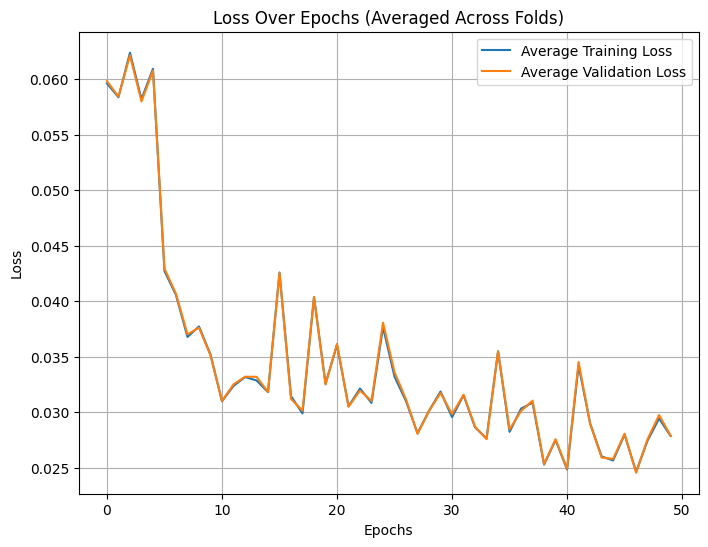

Evaluating Set 4 - Layers: [8, 16, 8, 1], Learning Rate: 0.01, Momentum: 0.9, Activation: relu
Epoch 1/50, Training Loss: 0.05796036899227936, Validation Loss: 0.06021763632779066
Epoch 2/50, Training Loss: 0.06276491586090553, Validation Loss: 0.06458625900378333
Epoch 3/50, Training Loss: 0.056818003365827555, Validation Loss: 0.05960368733829007
Epoch 4/50, Training Loss: 0.05728423358094126, Validation Loss: 0.06019220634755814
Epoch 5/50, Training Loss: 0.05715066933489758, Validation Loss: 0.05954998214939335
Epoch 6/50, Training Loss: 0.057973008176161515, Validation Loss: 0.06099761782029216
Epoch 7/50, Training Loss: 0.057921389832672206, Validation Loss: 0.06093954506588639
Epoch 8/50, Training Loss: 0.058620634275464524, Validation Loss: 0.060793983426277086
Epoch 9/50, Training Loss: 0.058430347105981766, Validation Loss: 0.06062208254470949
Epoch 10/50, Training Loss: 0.05944656838845508, Validation Loss: 0.06264470974143382
Epoch 11/50, Training Loss: 0.05859264735133402,

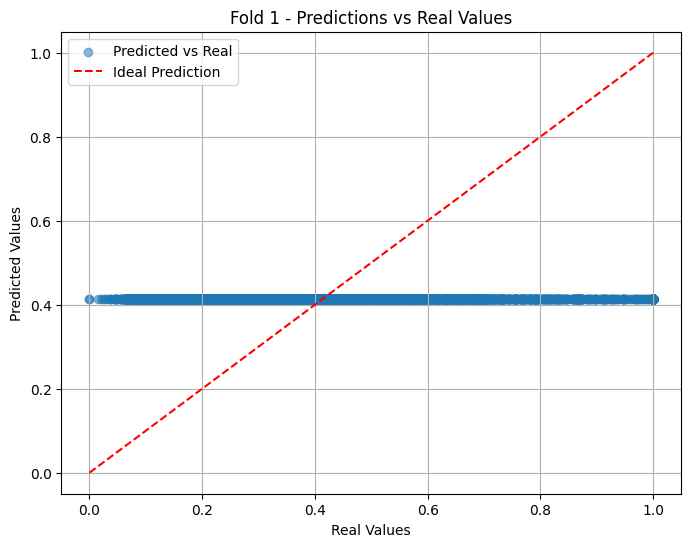

Epoch 1/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 2/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 3/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 4/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 5/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 6/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 7/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 8/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 9/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 10/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 11/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 12/50, Training Loss: 0.2164758905139149, Validation Loss: 0.2123134

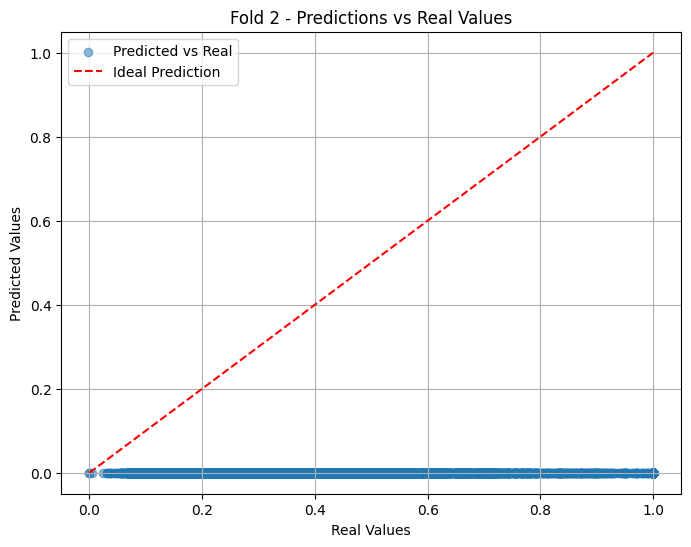

Epoch 1/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 2/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 3/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 4/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 5/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 6/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 7/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 8/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 9/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 10/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 11/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 12/50, Training Loss: 0.21630391127202583, Validation Los

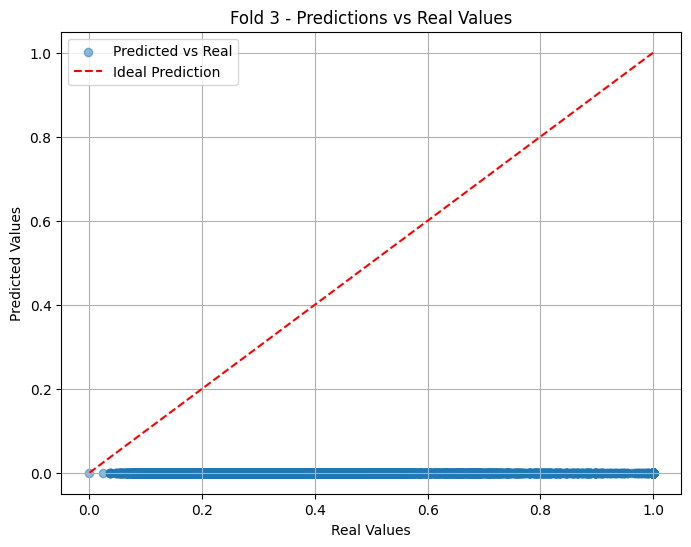

Epoch 1/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21608293850018254
Epoch 2/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21608293850018254
Epoch 3/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21608293850018254
Epoch 4/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21608293850018254
Epoch 5/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21608293850018254
Epoch 6/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21608293850018254
Epoch 7/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21608293850018254
Epoch 8/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21608293850018254
Epoch 9/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21608293850018254
Epoch 10/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21608293850018254
Epoch 11/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21608293850018254
Epoch 12/50, Training Loss: 0.2152083192625305, Validation Loss: 0.2160829

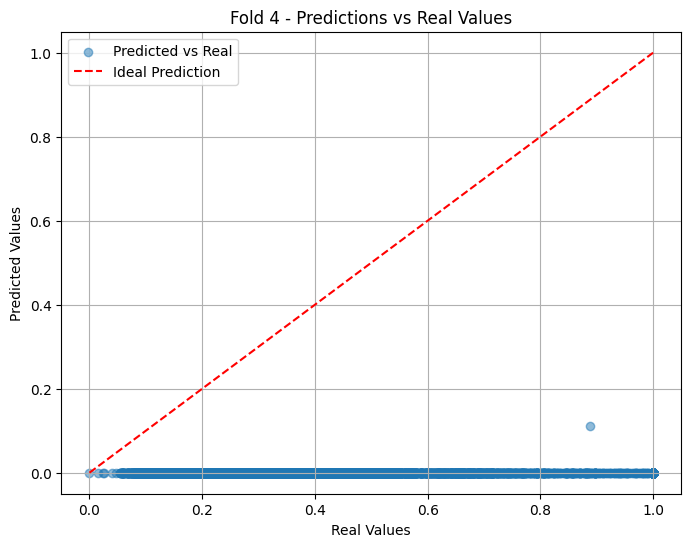

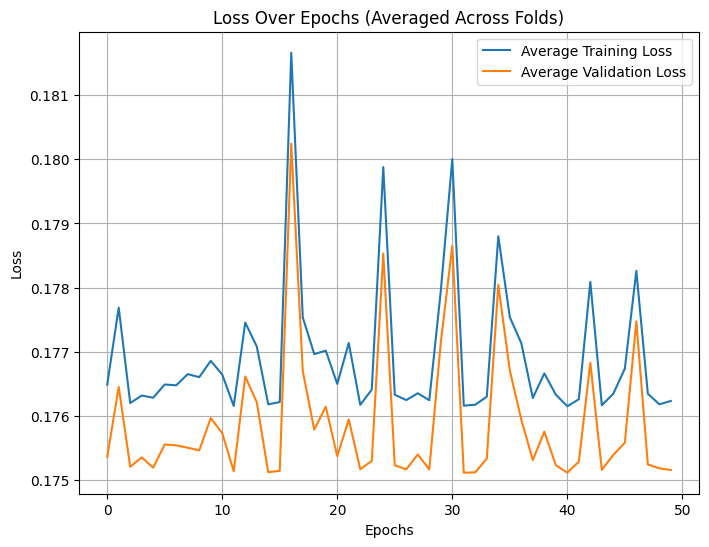

Evaluating Set 5 - Layers: [8, 8, 8, 1], Learning Rate: 1e-05, Momentum: 0.6, Activation: sigmoid
Epoch 1/50, Training Loss: 0.1058134822048358, Validation Loss: 0.10613708847690917
Epoch 2/50, Training Loss: 0.09960354466515858, Validation Loss: 0.1000781014829636
Epoch 3/50, Training Loss: 0.09401244938941358, Validation Loss: 0.09463255965932045
Epoch 4/50, Training Loss: 0.08898687527486393, Validation Loss: 0.08974743089548824
Epoch 5/50, Training Loss: 0.08456884612296733, Validation Loss: 0.0854621907348882
Epoch 6/50, Training Loss: 0.08078684465141808, Validation Loss: 0.0818024814366031
Epoch 7/50, Training Loss: 0.07739788151467873, Validation Loss: 0.07853153174285733
Epoch 8/50, Training Loss: 0.07449161454802014, Validation Loss: 0.07573440591161584
Epoch 9/50, Training Loss: 0.07194320035821158, Validation Loss: 0.0732892674849195
Epoch 10/50, Training Loss: 0.06976909765368067, Validation Loss: 0.07121030367299813
Epoch 11/50, Training Loss: 0.06789337722811065, Validat

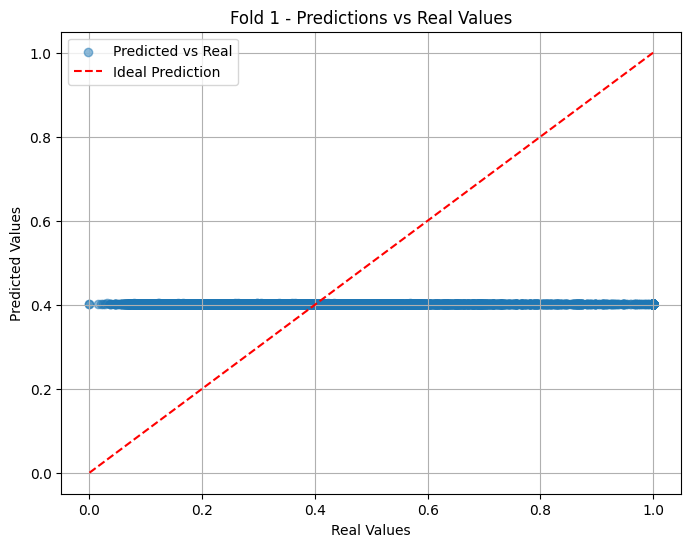

Epoch 1/50, Training Loss: 0.09340960712781834, Validation Loss: 0.09378511855120276
Epoch 2/50, Training Loss: 0.08776631847760107, Validation Loss: 0.08802187566934065
Epoch 3/50, Training Loss: 0.08285737389492245, Validation Loss: 0.08299909498799125
Epoch 4/50, Training Loss: 0.07877198034244316, Validation Loss: 0.07881021242712906
Epoch 5/50, Training Loss: 0.07529618127862567, Validation Loss: 0.07523819958810642
Epoch 6/50, Training Loss: 0.07238882799598423, Validation Loss: 0.07224283691488478
Epoch 7/50, Training Loss: 0.06997709937863685, Validation Loss: 0.06975129858484334
Epoch 8/50, Training Loss: 0.0679093445438366, Validation Loss: 0.06760868742045116
Epoch 9/50, Training Loss: 0.06619327348044943, Validation Loss: 0.06582458587002757
Epoch 10/50, Training Loss: 0.06474390529174656, Validation Loss: 0.0643122753474106
Epoch 11/50, Training Loss: 0.06356550311412264, Validation Loss: 0.06307783899067784
Epoch 12/50, Training Loss: 0.06259725519777137, Validation Loss:

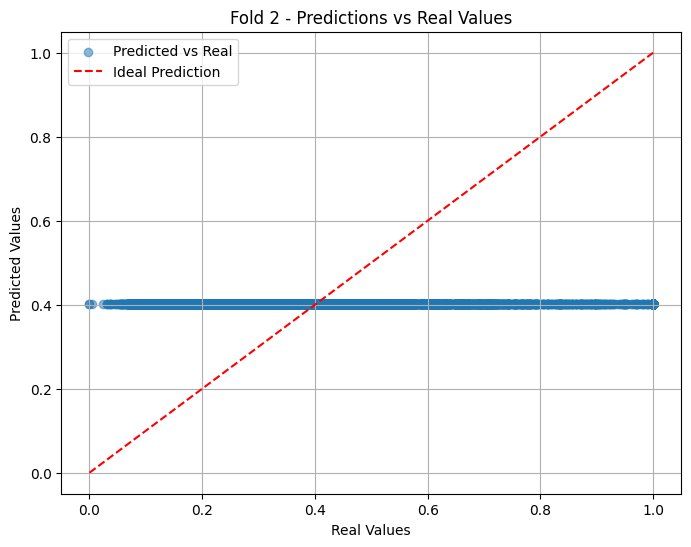

Epoch 1/50, Training Loss: 0.05792768655087419, Validation Loss: 0.0567656005875207
Epoch 2/50, Training Loss: 0.05788640968172898, Validation Loss: 0.0567177485874058
Epoch 3/50, Training Loss: 0.057842881776002816, Validation Loss: 0.05666674407146932
Epoch 4/50, Training Loss: 0.057807755309139244, Validation Loss: 0.056625072740714835
Epoch 5/50, Training Loss: 0.05778368068494389, Validation Loss: 0.05659618174124828
Epoch 6/50, Training Loss: 0.05775693697107859, Validation Loss: 0.056563693974190324
Epoch 7/50, Training Loss: 0.05773096846772458, Validation Loss: 0.05653164722630796
Epoch 8/50, Training Loss: 0.0577178110849874, Validation Loss: 0.05651517370678024
Epoch 9/50, Training Loss: 0.05770605423281024, Validation Loss: 0.05650028890845925
Epoch 10/50, Training Loss: 0.05769142246953084, Validation Loss: 0.05648150320254625
Epoch 11/50, Training Loss: 0.05768248767161224, Validation Loss: 0.05646986077316741
Epoch 12/50, Training Loss: 0.05767558576482658, Validation Lo

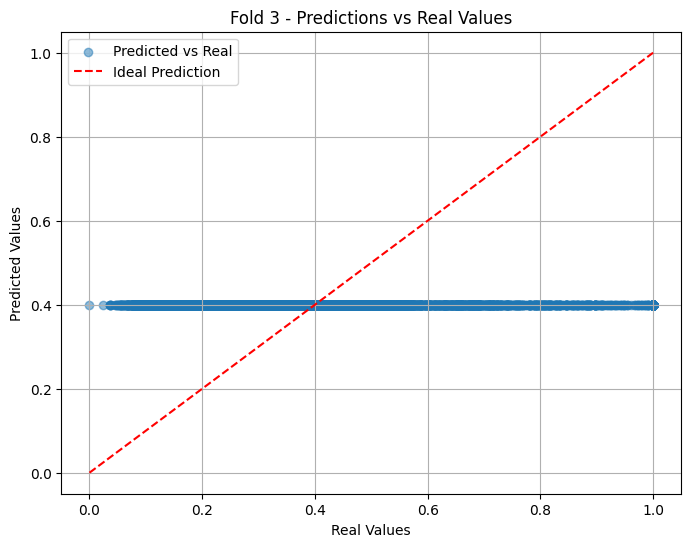

Epoch 1/50, Training Loss: 0.12260432451744113, Validation Loss: 0.12309505879098842
Epoch 2/50, Training Loss: 0.11879759264563142, Validation Loss: 0.11926609699384325
Epoch 3/50, Training Loss: 0.1148877394624797, Validation Loss: 0.11533268352972778
Epoch 4/50, Training Loss: 0.11098533302776896, Validation Loss: 0.11140595016217832
Epoch 5/50, Training Loss: 0.10698866259505842, Validation Loss: 0.10738343027819738
Epoch 6/50, Training Loss: 0.10305948441639227, Validation Loss: 0.10342780463424171
Epoch 7/50, Training Loss: 0.09912569378036336, Validation Loss: 0.0994663714017113
Epoch 8/50, Training Loss: 0.09518994952581103, Validation Loss: 0.09550163613401737
Epoch 9/50, Training Loss: 0.09139738085202624, Validation Loss: 0.09167966804831597
Epoch 10/50, Training Loss: 0.08773076879033648, Validation Loss: 0.08798303260868812
Epoch 11/50, Training Loss: 0.0843128133157765, Validation Loss: 0.08453541183610788
Epoch 12/50, Training Loss: 0.08101491125339347, Validation Loss: 

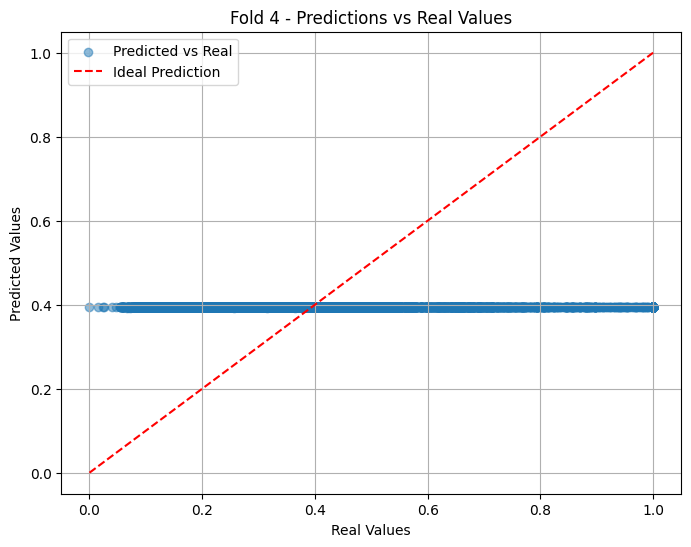

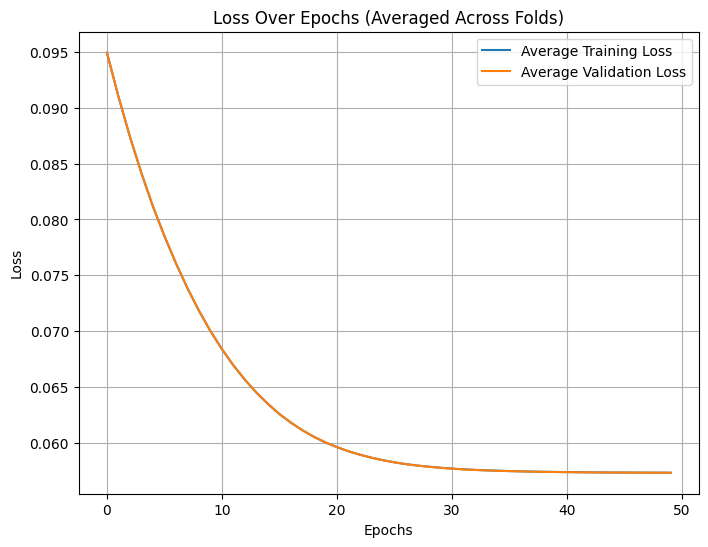

Evaluating Set 6 - Layers: [8, 20, 15, 1], Learning Rate: 0.001, Momentum: 0.3, Activation: relu
Epoch 1/50, Training Loss: 0.05641552138321365, Validation Loss: 0.0590609503486044
Epoch 2/50, Training Loss: 0.05639175227435184, Validation Loss: 0.0589872627283176
Epoch 3/50, Training Loss: 0.05643310190167969, Validation Loss: 0.05896674463530268
Epoch 4/50, Training Loss: 0.05656692411607126, Validation Loss: 0.059381135165861416
Epoch 5/50, Training Loss: 0.05622810302492067, Validation Loss: 0.058881197949057246
Epoch 6/50, Training Loss: 0.05655064309270444, Validation Loss: 0.05938732019750808
Epoch 7/50, Training Loss: 0.056262799967369534, Validation Loss: 0.05902194060803005
Epoch 8/50, Training Loss: 0.05611120366434165, Validation Loss: 0.05881802071965724
Epoch 9/50, Training Loss: 0.05600552556631645, Validation Loss: 0.05861853490219802
Epoch 10/50, Training Loss: 0.05663605269524941, Validation Loss: 0.05954073289090248
Epoch 11/50, Training Loss: 0.05604812673428213, Va

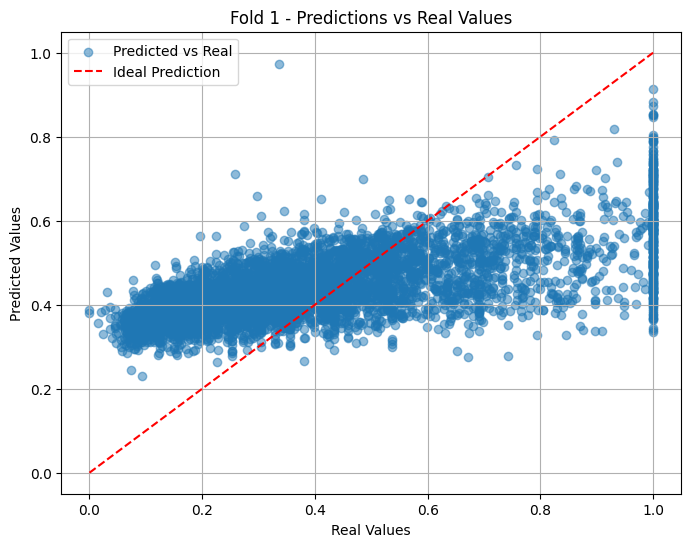

Epoch 1/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 2/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 3/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 4/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 5/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 6/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 7/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 8/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 9/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 10/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 11/50, Training Loss: 0.2164758905139149, Validation Loss: 0.21231344908335828
Epoch 12/50, Training Loss: 0.2164758905139149, Validation Loss: 0.2123134

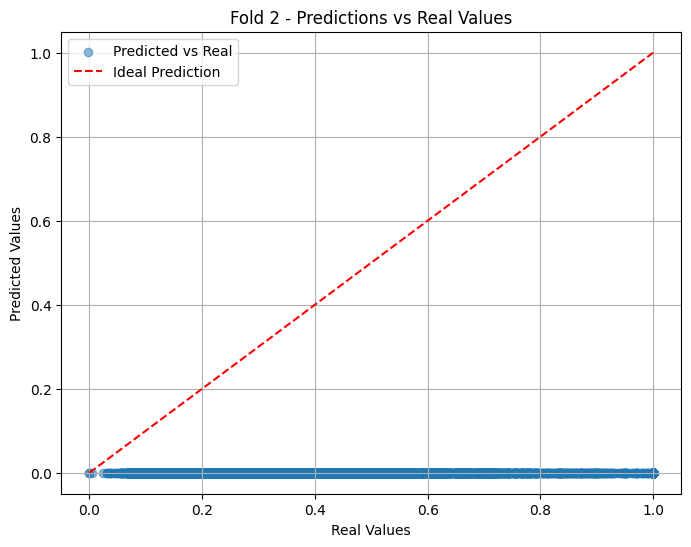

Epoch 1/50, Training Loss: 0.057429580557916006, Validation Loss: 0.056081320733121526
Epoch 2/50, Training Loss: 0.057308270089286156, Validation Loss: 0.055977479540912825
Epoch 3/50, Training Loss: 0.05718660279693486, Validation Loss: 0.05594234827159489
Epoch 4/50, Training Loss: 0.05744661450270261, Validation Loss: 0.05607328852147159
Epoch 5/50, Training Loss: 0.05728395148014278, Validation Loss: 0.055931850147586816
Epoch 6/50, Training Loss: 0.05705845592754453, Validation Loss: 0.055770741474718014
Epoch 7/50, Training Loss: 0.058332531373758385, Validation Loss: 0.05725758606224075
Epoch 8/50, Training Loss: 0.05743227961265268, Validation Loss: 0.05627293165628722
Epoch 9/50, Training Loss: 0.057674820004993535, Validation Loss: 0.056243965191246956
Epoch 10/50, Training Loss: 0.0573078590709583, Validation Loss: 0.05591361394576476
Epoch 11/50, Training Loss: 0.05700204302304198, Validation Loss: 0.055651212728851256
Epoch 12/50, Training Loss: 0.05694939981554718, Valid

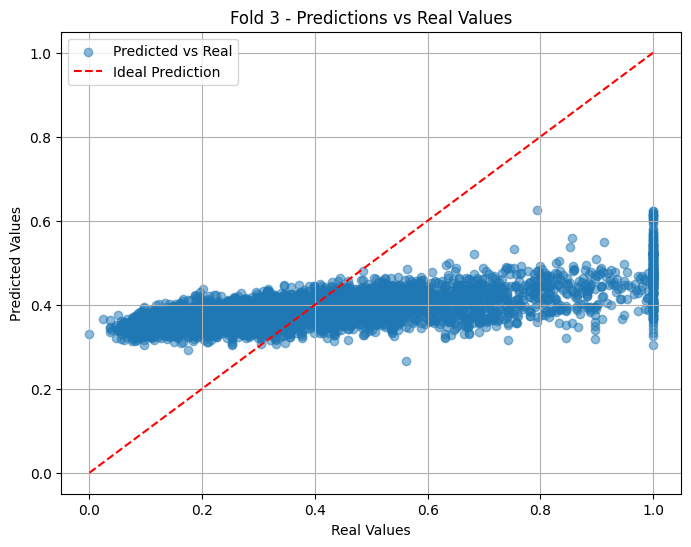

Epoch 1/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 2/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 3/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 4/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 5/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 6/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 7/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 8/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 9/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 10/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 11/50, Training Loss: 0.2152083192625305, Validation Loss: 0.21611639040865185
Epoch 12/50, Training Loss: 0.2152083192625305, Validation Loss: 0.2161163

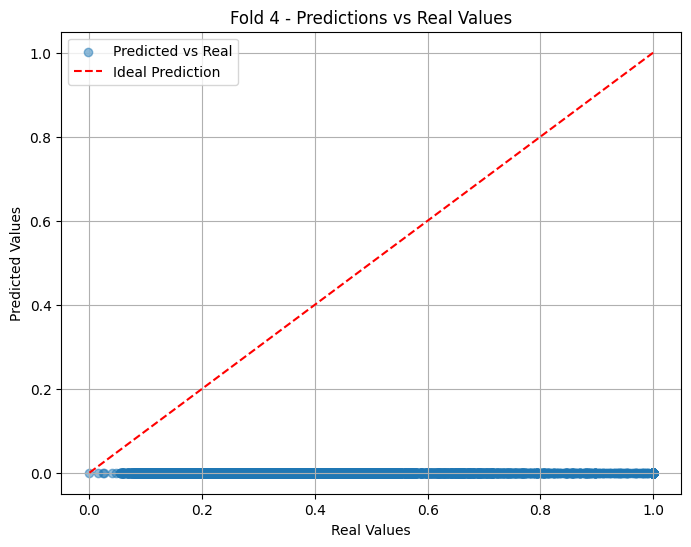

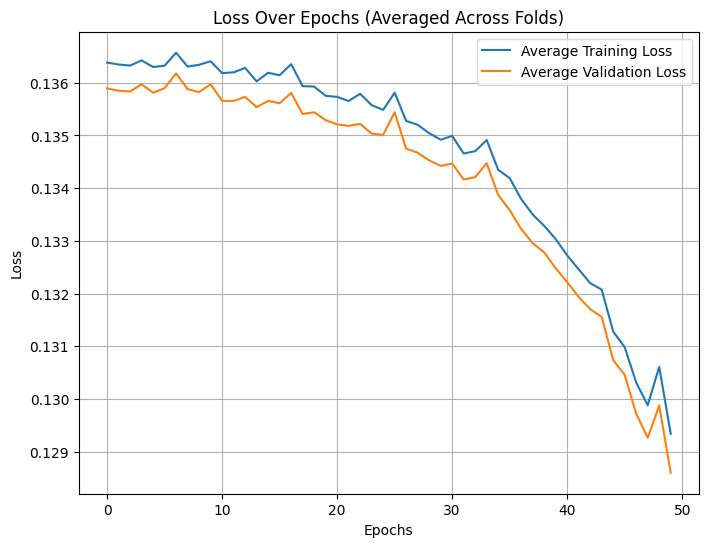

Evaluating Set 7 - Layers: [8, 12, 8, 1], Learning Rate: 0.01, Momentum: 0.8, Activation: tanh
Epoch 1/50, Training Loss: 0.05568139103680126, Validation Loss: 0.05812316303492087
Epoch 2/50, Training Loss: 0.057724649245271875, Validation Loss: 0.05965057747894804
Epoch 3/50, Training Loss: 0.056692678644697396, Validation Loss: 0.058349313143938666
Epoch 4/50, Training Loss: 0.04426999752309068, Validation Loss: 0.04678783510202117
Epoch 5/50, Training Loss: 0.04079096281379556, Validation Loss: 0.04311940808439915
Epoch 6/50, Training Loss: 0.03673455405941191, Validation Loss: 0.03853744315683672
Epoch 7/50, Training Loss: 0.09017814247556495, Validation Loss: 0.09028598489128357
Epoch 8/50, Training Loss: 0.0388908588406888, Validation Loss: 0.041052563623502895
Epoch 9/50, Training Loss: 0.031762241187253536, Validation Loss: 0.03340828458428986
Epoch 10/50, Training Loss: 0.0323870154889916, Validation Loss: 0.033765886424504815
Epoch 11/50, Training Loss: 0.044324764201692235, 

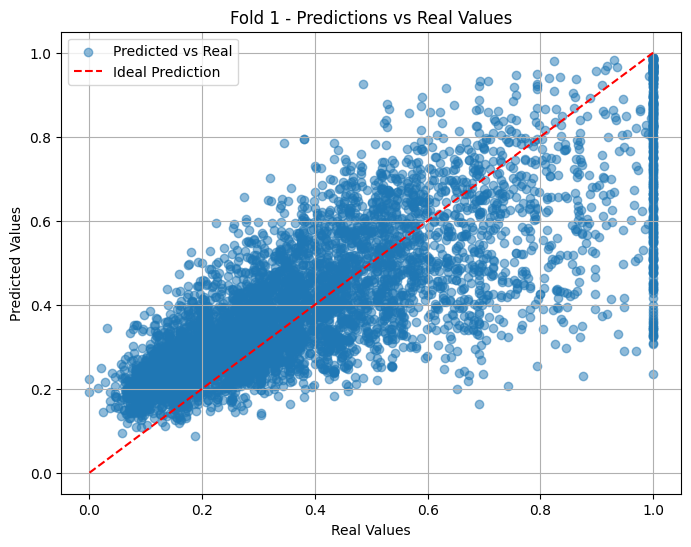

Epoch 1/50, Training Loss: 0.057498720755430485, Validation Loss: 0.05664338844858924
Epoch 2/50, Training Loss: 0.05931989024601997, Validation Loss: 0.057922504892672616
Epoch 3/50, Training Loss: 0.05848989078920598, Validation Loss: 0.05791232829750957
Epoch 4/50, Training Loss: 0.05340710271047515, Validation Loss: 0.05254277996301149
Epoch 5/50, Training Loss: 0.06720555495406359, Validation Loss: 0.06741623959894612
Epoch 6/50, Training Loss: 0.04099757339542212, Validation Loss: 0.04088281634917328
Epoch 7/50, Training Loss: 0.038141649904333504, Validation Loss: 0.038138477901881164
Epoch 8/50, Training Loss: 0.0351154570665014, Validation Loss: 0.03524026355118128
Epoch 9/50, Training Loss: 0.03283733893515043, Validation Loss: 0.0329704819622117
Epoch 10/50, Training Loss: 0.034359216960984686, Validation Loss: 0.03447105862125636
Epoch 11/50, Training Loss: 0.030959214705874268, Validation Loss: 0.03119467410589524
Epoch 12/50, Training Loss: 0.031052425138482102, Validatio

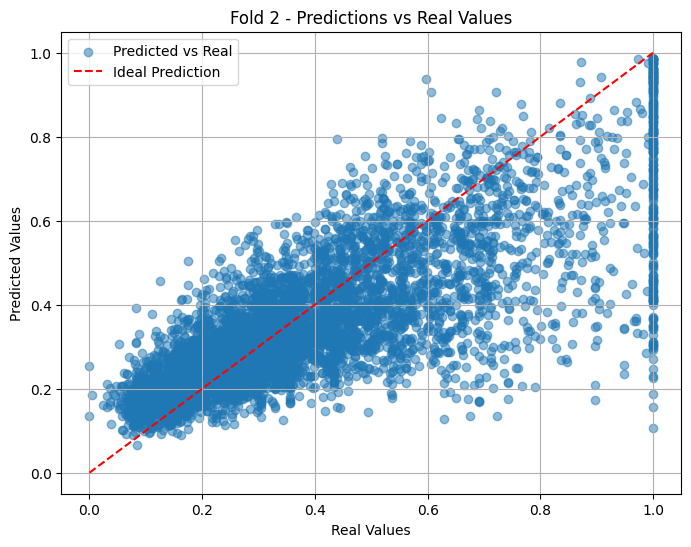

Epoch 1/50, Training Loss: 0.05777893909728482, Validation Loss: 0.056695124523313156
Epoch 2/50, Training Loss: 0.057914662461205337, Validation Loss: 0.05626250493570366
Epoch 3/50, Training Loss: 0.051853707338477086, Validation Loss: 0.05030401293617288
Epoch 4/50, Training Loss: 0.0462420760320336, Validation Loss: 0.04484035148373344
Epoch 5/50, Training Loss: 0.042500151333545434, Validation Loss: 0.04058386121183644
Epoch 6/50, Training Loss: 0.038518857333290385, Validation Loss: 0.037182471824689096
Epoch 7/50, Training Loss: 0.03618736234788499, Validation Loss: 0.03426967537082679
Epoch 8/50, Training Loss: 0.03301040121488543, Validation Loss: 0.031336991626246494
Epoch 9/50, Training Loss: 0.033772367453839804, Validation Loss: 0.03244127121385063
Epoch 10/50, Training Loss: 0.04637317030627684, Validation Loss: 0.04388556353915594
Epoch 11/50, Training Loss: 0.046855707944791054, Validation Loss: 0.04435241861791859
Epoch 12/50, Training Loss: 0.03074862448581331, Valida

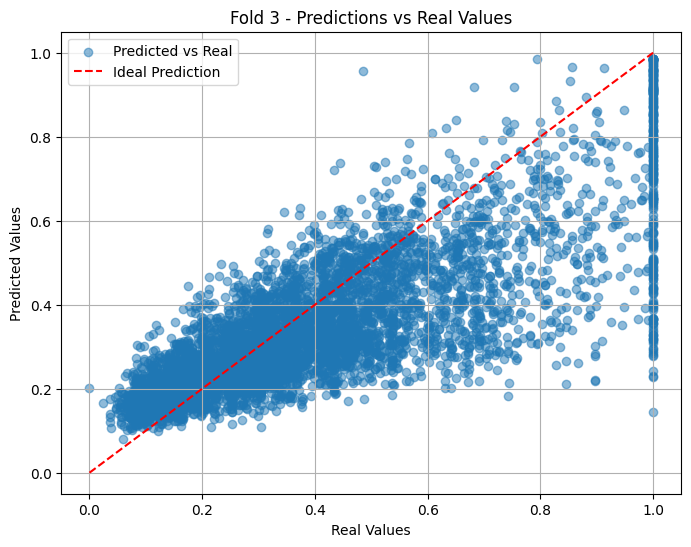

Epoch 1/50, Training Loss: 0.05676649667743693, Validation Loss: 0.05653660145643945
Epoch 2/50, Training Loss: 0.056093812799524786, Validation Loss: 0.05579500393659902
Epoch 3/50, Training Loss: 0.05442877913630969, Validation Loss: 0.054202115535315364
Epoch 4/50, Training Loss: 0.053667033936829964, Validation Loss: 0.05327452602985095
Epoch 5/50, Training Loss: 0.044799161796078506, Validation Loss: 0.044597837221267825
Epoch 6/50, Training Loss: 0.03876987581932004, Validation Loss: 0.03864536580761631
Epoch 7/50, Training Loss: 0.037561521351983, Validation Loss: 0.03753566584079072
Epoch 8/50, Training Loss: 0.03715742582814673, Validation Loss: 0.0371877182706487
Epoch 9/50, Training Loss: 0.054313702998402096, Validation Loss: 0.05436981698023212
Epoch 10/50, Training Loss: 0.03081610069717861, Validation Loss: 0.030928857710497474
Epoch 11/50, Training Loss: 0.048493570799077894, Validation Loss: 0.048718468562596116
Epoch 12/50, Training Loss: 0.02885430607552812, Validati

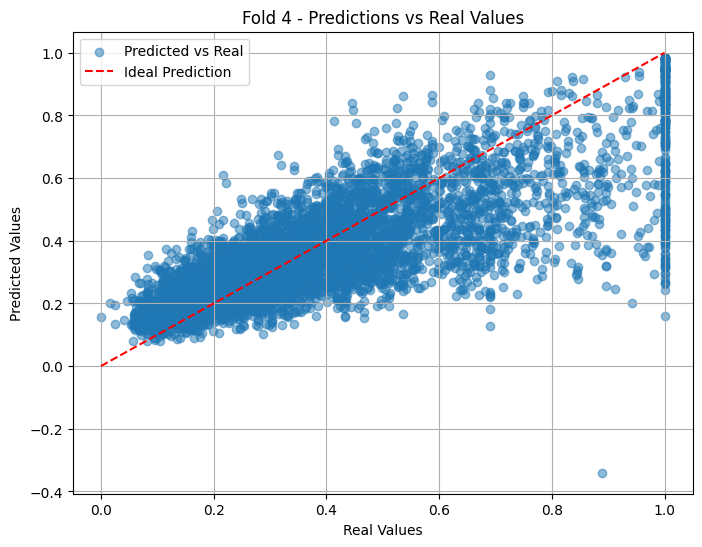

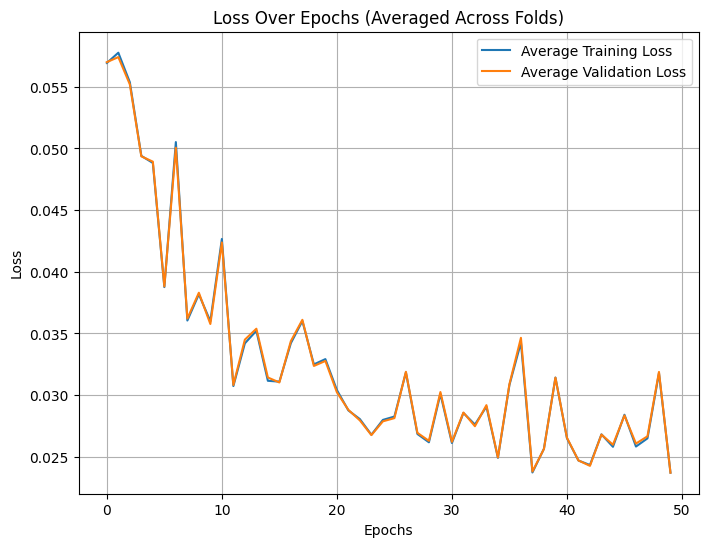

Evaluating Set 8 - Layers: [8, 15, 1], Learning Rate: 0.0001, Momentum: 0.4, Activation: linear
Epoch 1/50, Training Loss: 0.05725709519025127, Validation Loss: 0.059948691201612773
Epoch 2/50, Training Loss: 0.05719508267782151, Validation Loss: 0.059751284730626006
Epoch 3/50, Training Loss: 0.057161018411625256, Validation Loss: 0.059746373119293796
Epoch 4/50, Training Loss: 0.05714722029817021, Validation Loss: 0.0597248914809171
Epoch 5/50, Training Loss: 0.05715014325317246, Validation Loss: 0.05970036485330679
Epoch 6/50, Training Loss: 0.05711890009096538, Validation Loss: 0.05975919475945191
Epoch 7/50, Training Loss: 0.057119435198678736, Validation Loss: 0.05977989292894553
Epoch 8/50, Training Loss: 0.05709920502431169, Validation Loss: 0.05964900707624749
Epoch 9/50, Training Loss: 0.0570578650151141, Validation Loss: 0.05965083560188026
Epoch 10/50, Training Loss: 0.05704878562035696, Validation Loss: 0.059620160334987585
Epoch 11/50, Training Loss: 0.05702504352633079, 

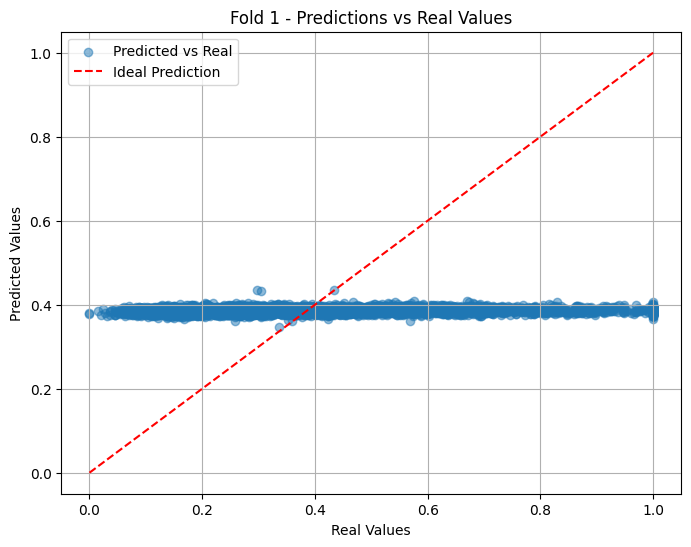

Epoch 1/50, Training Loss: 0.05668814091339516, Validation Loss: 0.05575015931128801
Epoch 2/50, Training Loss: 0.05664177605067247, Validation Loss: 0.0556788472073326
Epoch 3/50, Training Loss: 0.0566250950724933, Validation Loss: 0.05566638867141626
Epoch 4/50, Training Loss: 0.05677418609799285, Validation Loss: 0.05589648810592415
Epoch 5/50, Training Loss: 0.05659821004801159, Validation Loss: 0.055590985003154916
Epoch 6/50, Training Loss: 0.05657414629665248, Validation Loss: 0.055622902275483006
Epoch 7/50, Training Loss: 0.05654580139030749, Validation Loss: 0.05556951572235694
Epoch 8/50, Training Loss: 0.05652797539327515, Validation Loss: 0.055562243708792064
Epoch 9/50, Training Loss: 0.0565466710776284, Validation Loss: 0.055527830694444905
Epoch 10/50, Training Loss: 0.056493000928905544, Validation Loss: 0.05550826921487013
Epoch 11/50, Training Loss: 0.05650527783421177, Validation Loss: 0.05558040293957398
Epoch 12/50, Training Loss: 0.05656006989091965, Validation L

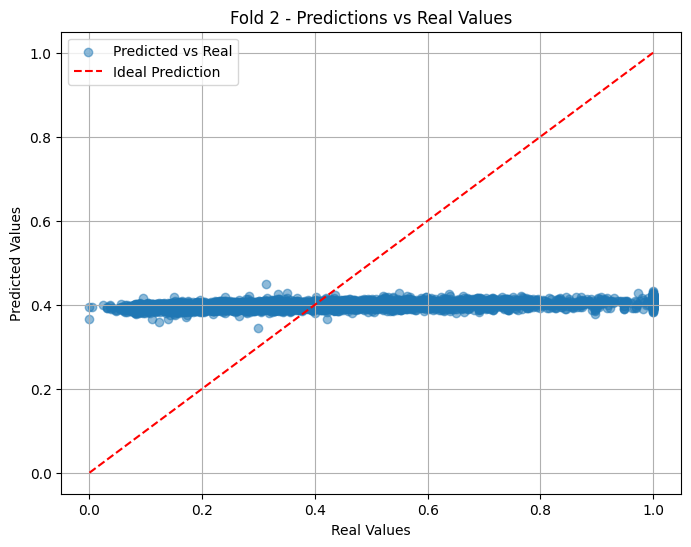

Epoch 1/50, Training Loss: 0.05723261407232702, Validation Loss: 0.05593556391487804
Epoch 2/50, Training Loss: 0.05721820871381223, Validation Loss: 0.05592078327589622
Epoch 3/50, Training Loss: 0.05721108417164612, Validation Loss: 0.055902933654129364
Epoch 4/50, Training Loss: 0.057214960071743565, Validation Loss: 0.055893435494658465
Epoch 5/50, Training Loss: 0.05718075052474803, Validation Loss: 0.055900892910240786
Epoch 6/50, Training Loss: 0.057179126628003, Validation Loss: 0.055861057536880095
Epoch 7/50, Training Loss: 0.05716575739081315, Validation Loss: 0.05584684263611291
Epoch 8/50, Training Loss: 0.05714188220148192, Validation Loss: 0.05586404715345207
Epoch 9/50, Training Loss: 0.057157533548221194, Validation Loss: 0.05589719179527669
Epoch 10/50, Training Loss: 0.05719063196967235, Validation Loss: 0.05594692176913012
Epoch 11/50, Training Loss: 0.05708990224781794, Validation Loss: 0.055793258984518236
Epoch 12/50, Training Loss: 0.05707630223540079, Validatio

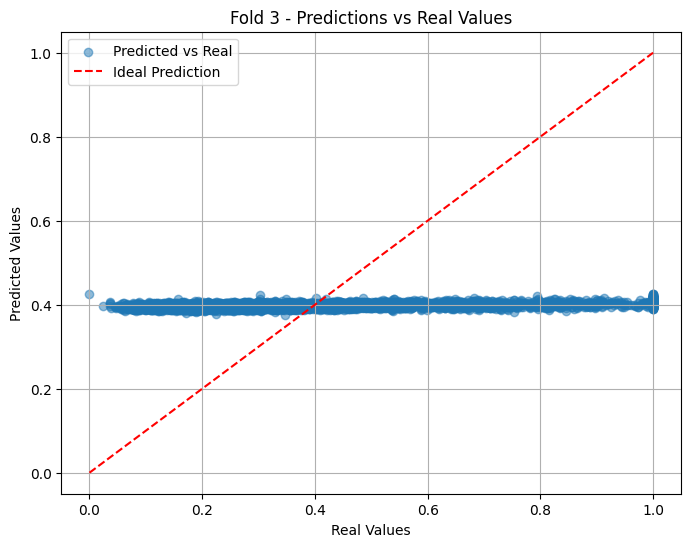

Epoch 1/50, Training Loss: 0.056480553695715884, Validation Loss: 0.056154636976668997
Epoch 2/50, Training Loss: 0.05645738375398137, Validation Loss: 0.056152929965390404
Epoch 3/50, Training Loss: 0.05643012659726283, Validation Loss: 0.05610910202136048
Epoch 4/50, Training Loss: 0.05649605348198338, Validation Loss: 0.056151783948009015
Epoch 5/50, Training Loss: 0.05638833303369672, Validation Loss: 0.05606756223711704
Epoch 6/50, Training Loss: 0.05646077178098927, Validation Loss: 0.05611511513491219
Epoch 7/50, Training Loss: 0.056352284396822286, Validation Loss: 0.05604451995882592
Epoch 8/50, Training Loss: 0.05632492889537428, Validation Loss: 0.056009258619432255
Epoch 9/50, Training Loss: 0.0563077886221007, Validation Loss: 0.055996386859603474
Epoch 10/50, Training Loss: 0.056289062787249836, Validation Loss: 0.055978925645305024
Epoch 11/50, Training Loss: 0.05630738249679337, Validation Loss: 0.055970009997288996
Epoch 12/50, Training Loss: 0.05624486905750485, Valid

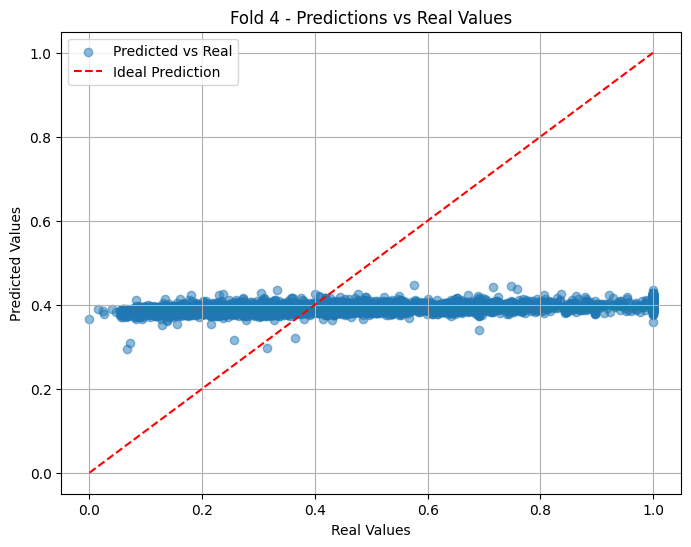

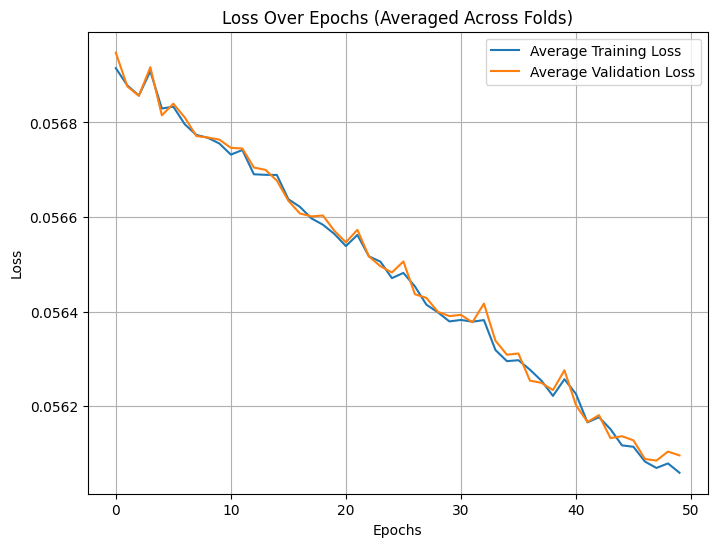

Evaluating Set 9 - Layers: [8, 18, 14, 1], Learning Rate: 0.0001, Momentum: 0.5, Activation: relu
Epoch 1/50, Training Loss: 0.05640112114429278, Validation Loss: 0.059038774550373575
Epoch 2/50, Training Loss: 0.05639251797007927, Validation Loss: 0.05901732548425089
Epoch 3/50, Training Loss: 0.056391564626016466, Validation Loss: 0.058990099894442996
Epoch 4/50, Training Loss: 0.056391956372753786, Validation Loss: 0.05905348277228591
Epoch 5/50, Training Loss: 0.056372022933104754, Validation Loss: 0.05899084596249495
Epoch 6/50, Training Loss: 0.05636620015123997, Validation Loss: 0.05900147673420449
Epoch 7/50, Training Loss: 0.05654004828246193, Validation Loss: 0.05930317195061501
Epoch 8/50, Training Loss: 0.05639093532390318, Validation Loss: 0.0589486739377055
Epoch 9/50, Training Loss: 0.0563550557073132, Validation Loss: 0.05894393657220247
Epoch 10/50, Training Loss: 0.05639555480558464, Validation Loss: 0.05909753755151601
Epoch 11/50, Training Loss: 0.056330807650743345

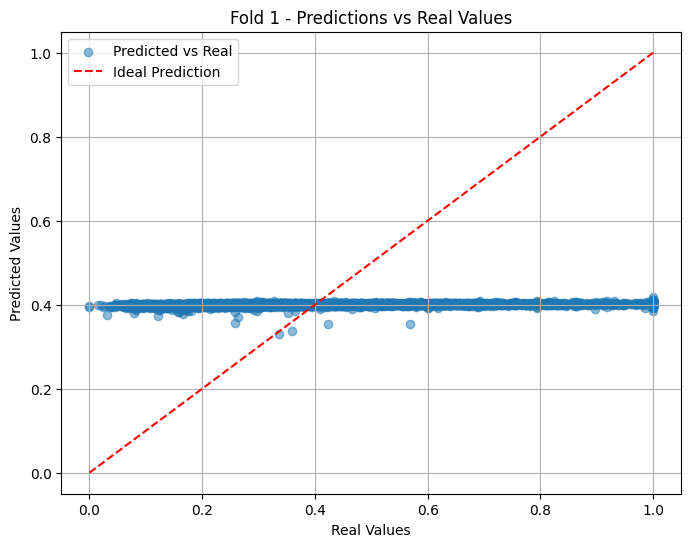

Epoch 1/50, Training Loss: 0.0582469438729844, Validation Loss: 0.05714666189038702
Epoch 2/50, Training Loss: 0.058265679111763446, Validation Loss: 0.05718568767513205
Epoch 3/50, Training Loss: 0.05817767458145282, Validation Loss: 0.057055948079678745
Epoch 4/50, Training Loss: 0.05814802755252311, Validation Loss: 0.057002096705805236
Epoch 5/50, Training Loss: 0.058169227625192624, Validation Loss: 0.05697483872016127
Epoch 6/50, Training Loss: 0.05814022171664247, Validation Loss: 0.057035104947792625
Epoch 7/50, Training Loss: 0.05809660168853996, Validation Loss: 0.05695945609835644
Epoch 8/50, Training Loss: 0.05813912621947819, Validation Loss: 0.05705621536544706
Epoch 9/50, Training Loss: 0.058247984289885674, Validation Loss: 0.05721149178355088
Epoch 10/50, Training Loss: 0.05810419710545672, Validation Loss: 0.05702349164815642
Epoch 11/50, Training Loss: 0.05803886248735024, Validation Loss: 0.05692684491718398
Epoch 12/50, Training Loss: 0.058009615357602254, Validati

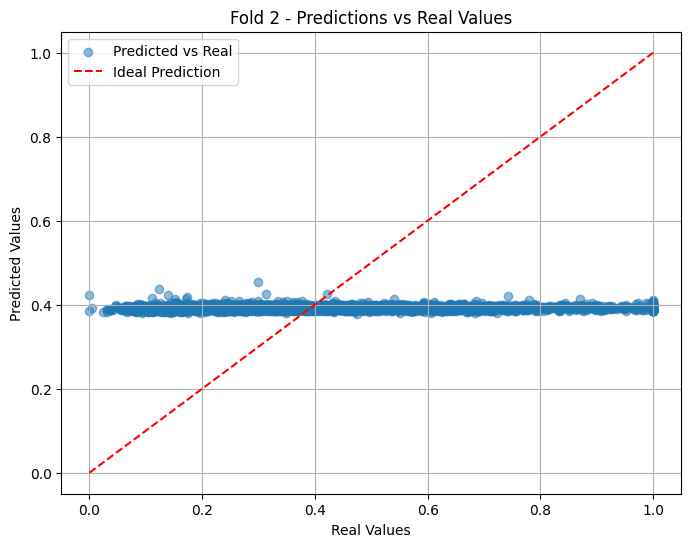

Epoch 1/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 2/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 3/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 4/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 5/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 6/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 7/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 8/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 9/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 10/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 11/50, Training Loss: 0.21630391127202583, Validation Loss: 0.21282941768501148
Epoch 12/50, Training Loss: 0.21630391127202583, Validation Los

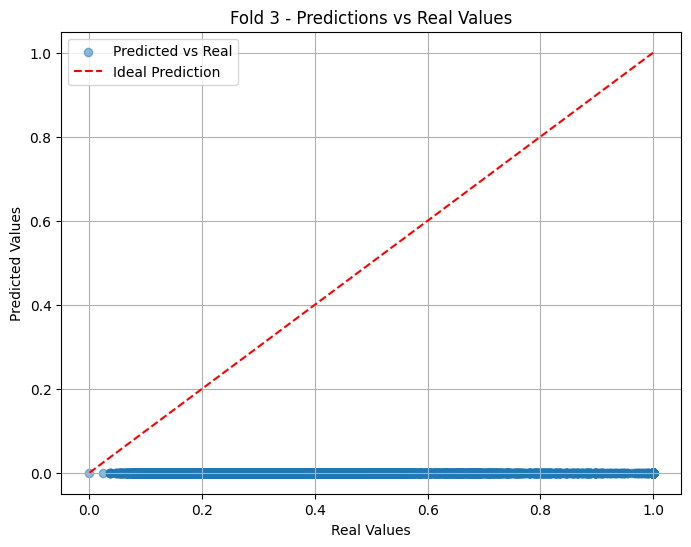

Epoch 1/50, Training Loss: 0.05708497039530465, Validation Loss: 0.05679533655617664
Epoch 2/50, Training Loss: 0.05703946857338212, Validation Loss: 0.056770282809747497
Epoch 3/50, Training Loss: 0.0570344131632631, Validation Loss: 0.05676340256457187
Epoch 4/50, Training Loss: 0.057037712429229316, Validation Loss: 0.05675852951834845
Epoch 5/50, Training Loss: 0.05703309566633235, Validation Loss: 0.056770640239643795
Epoch 6/50, Training Loss: 0.05705828199486612, Validation Loss: 0.056769236590647094
Epoch 7/50, Training Loss: 0.05704162972020297, Validation Loss: 0.05678577995751668
Epoch 8/50, Training Loss: 0.057010587259835696, Validation Loss: 0.05673985014587397
Epoch 9/50, Training Loss: 0.057007083239057205, Validation Loss: 0.056732613291519664
Epoch 10/50, Training Loss: 0.057002997543273384, Validation Loss: 0.05672754048353377
Epoch 11/50, Training Loss: 0.05703838623552902, Validation Loss: 0.056786603793908375
Epoch 12/50, Training Loss: 0.05702917009316872, Valida

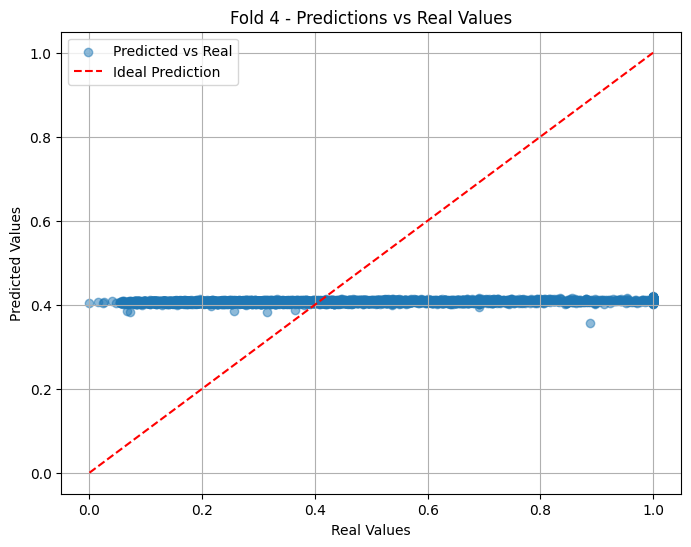

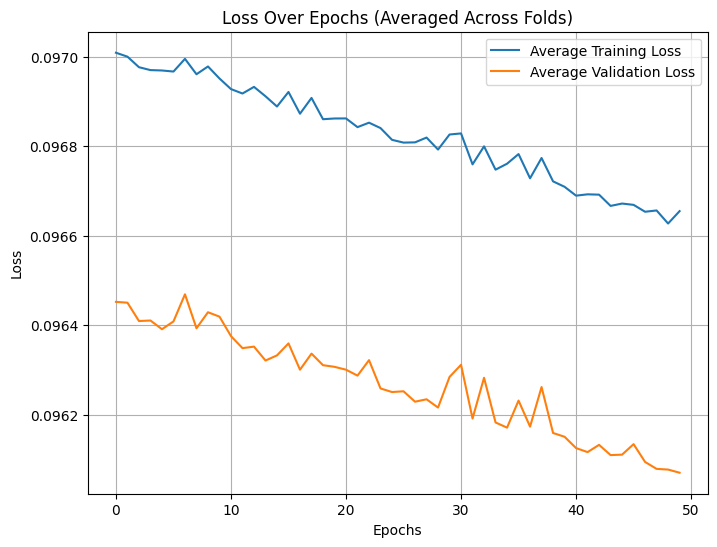

Evaluating Set 10 - Layers: [8, 14, 7, 1], Learning Rate: 1e-05, Momentum: 0.7, Activation: sigmoid
Epoch 1/50, Training Loss: 0.08331414588817204, Validation Loss: 0.08424759675303628
Epoch 2/50, Training Loss: 0.07768671743173543, Validation Loss: 0.07881044994618286
Epoch 3/50, Training Loss: 0.073179961091659, Validation Loss: 0.07447539785969541
Epoch 4/50, Training Loss: 0.06953063145632792, Validation Loss: 0.07098319796968874
Epoch 5/50, Training Loss: 0.06681476767170337, Validation Loss: 0.0683993825818423
Epoch 6/50, Training Loss: 0.06465327065533111, Validation Loss: 0.06635622003512305
Epoch 7/50, Training Loss: 0.0629575943549045, Validation Loss: 0.06476510238763276
Epoch 8/50, Training Loss: 0.06163857003835619, Validation Loss: 0.06353757809947079
Epoch 9/50, Training Loss: 0.0605930418137155, Validation Loss: 0.06257357001050039
Epoch 10/50, Training Loss: 0.05976249023741503, Validation Loss: 0.061815829131742585
Epoch 11/50, Training Loss: 0.0591093232514709, Valid

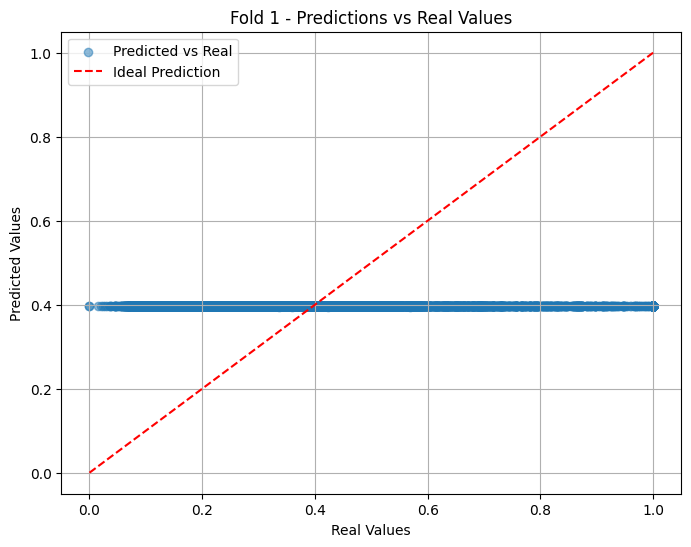

Epoch 1/50, Training Loss: 0.06069560450316029, Validation Loss: 0.06004250605217653
Epoch 2/50, Training Loss: 0.060072532984595146, Validation Loss: 0.05937416306311311
Epoch 3/50, Training Loss: 0.05957302968360006, Validation Loss: 0.05883412488168475
Epoch 4/50, Training Loss: 0.05916147198301258, Validation Loss: 0.058385204943531444
Epoch 5/50, Training Loss: 0.058821166889605134, Validation Loss: 0.05801019510351252
Epoch 6/50, Training Loss: 0.05857616677078467, Validation Loss: 0.0577372059514918
Epoch 7/50, Training Loss: 0.05837283771784776, Validation Loss: 0.0575079712181323
Epoch 8/50, Training Loss: 0.05820089801259975, Validation Loss: 0.057311475079953836
Epoch 9/50, Training Loss: 0.05806452524403938, Validation Loss: 0.05715318354459083
Epoch 10/50, Training Loss: 0.05796582215801305, Validation Loss: 0.057036714135851124
Epoch 11/50, Training Loss: 0.05788627432735065, Validation Loss: 0.05694122433630221
Epoch 12/50, Training Loss: 0.05782747067872003, Validation 

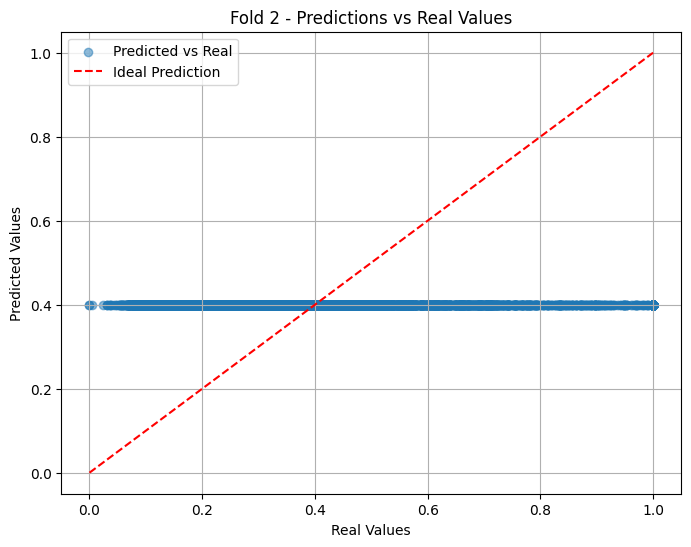

Epoch 1/50, Training Loss: 0.07181722281343543, Validation Loss: 0.06989291206498355
Epoch 2/50, Training Loss: 0.07009909246179628, Validation Loss: 0.0682160773605468
Epoch 3/50, Training Loss: 0.06851404096754324, Validation Loss: 0.06667172279043701
Epoch 4/50, Training Loss: 0.06713138728684653, Validation Loss: 0.06532705731715735
Epoch 5/50, Training Loss: 0.06585519289234926, Validation Loss: 0.06408845704932072
Epoch 6/50, Training Loss: 0.06474972386235493, Validation Loss: 0.0630179784463301
Epoch 7/50, Training Loss: 0.0637804414334592, Validation Loss: 0.06208167623870638
Epoch 8/50, Training Loss: 0.06294723011833789, Validation Loss: 0.06127894956785204
Epoch 9/50, Training Loss: 0.0621738969429155, Validation Loss: 0.06053611678176596
Epoch 10/50, Training Loss: 0.06153324775269701, Validation Loss: 0.059922750966949004
Epoch 11/50, Training Loss: 0.060986289830098926, Validation Loss: 0.059400903048618385
Epoch 12/50, Training Loss: 0.060492550325431056, Validation Los

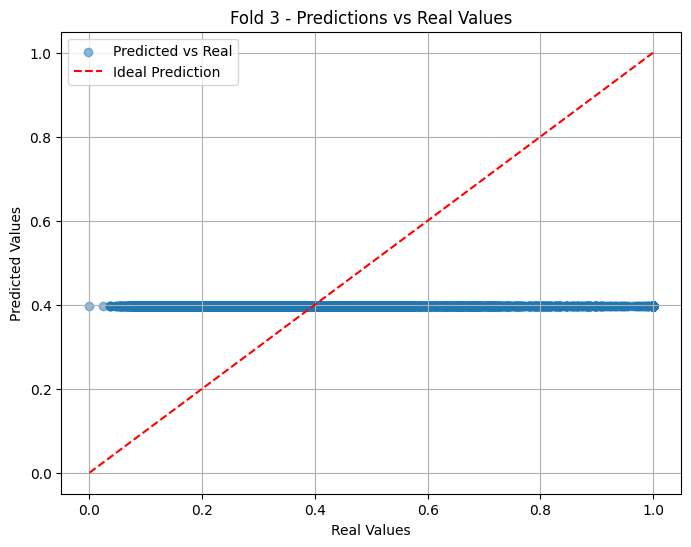

Epoch 1/50, Training Loss: 0.08408411052365232, Validation Loss: 0.0843054407985979
Epoch 2/50, Training Loss: 0.08133768660321755, Validation Loss: 0.08153365911591988
Epoch 3/50, Training Loss: 0.07875431994119635, Validation Loss: 0.07892507664565933
Epoch 4/50, Training Loss: 0.07636397350259493, Validation Loss: 0.07651000252450275
Epoch 5/50, Training Loss: 0.07412582290178933, Validation Loss: 0.07424724444358953
Epoch 6/50, Training Loss: 0.07207482640969554, Validation Loss: 0.07217220946885464
Epoch 7/50, Training Loss: 0.07023514263303772, Validation Loss: 0.0703094925488923
Epoch 8/50, Training Loss: 0.06855801632404433, Validation Loss: 0.068609885078453
Epoch 9/50, Training Loss: 0.0671049285804979, Validation Loss: 0.06713591383611728
Epoch 10/50, Training Loss: 0.06576827782976649, Validation Loss: 0.0657786273770249
Epoch 11/50, Training Loss: 0.06458298337142736, Validation Loss: 0.06457361130169914
Epoch 12/50, Training Loss: 0.06359260746157733, Validation Loss: 0.0

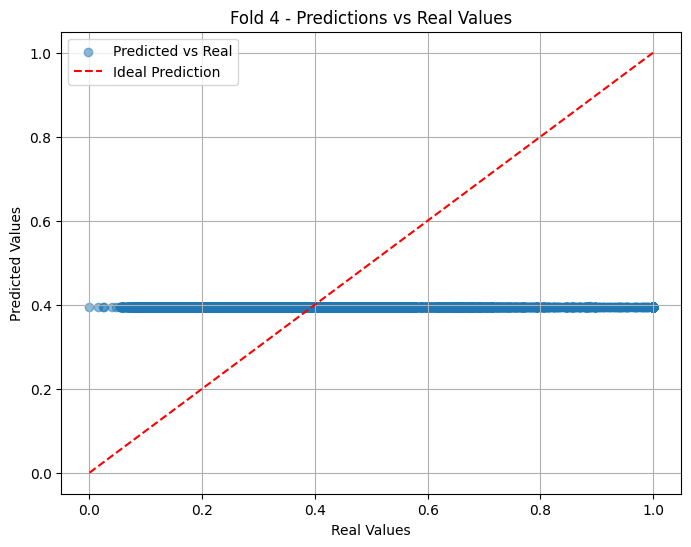

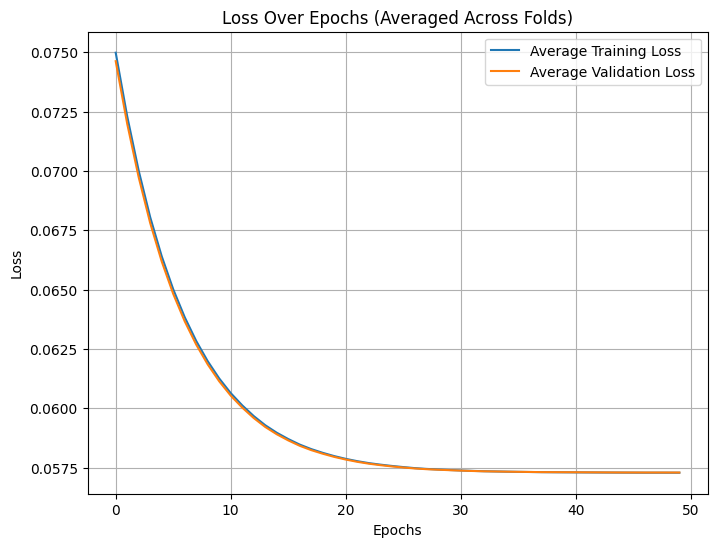

   Set  MSE_Mean   MSE_Std  MAE_Mean   MAE_Std  MAPE_Mean   MAPE_Std
0    7  0.023701  0.000791  0.109102  0.002523  33.886342   3.107062
1    3  0.027882  0.005097  0.130448  0.022859  48.669457  14.519249
2    8  0.056096  0.001800  0.186578  0.002209  73.804976   1.695651
3    1  0.057266  0.001176  0.189602  0.001779  75.860428   1.102726
4    5  0.057294  0.001160  0.189848  0.002472  76.135694   1.892256
5   10  0.057297  0.001172  0.189436  0.002133  75.596758   1.583567
6    2  0.079735  0.077681  0.202689  0.114981  61.522469  27.169524
7    9  0.096071  0.067417  0.241427  0.089025  82.194416  10.282867
8    6  0.128600  0.085636  0.281226  0.115575  83.653123  16.523583
9    4  0.175158  0.066845  0.346326  0.086724  95.147956   8.402681
Best Hyperparameter Set: Set           7.000000
MSE_Mean      0.023701
MSE_Std       0.000791
MAE_Mean      0.109102
MAE_Std       0.002523
MAPE_Mean    33.886342
MAPE_Std      3.107062
Name: 0, dtype: float64


In [4]:
# Function to calculate MAPE without masking
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Create a mask to exclude zero or near-zero values in y_true
    mask = y_true > 1e-10
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]
    
    # Calculate MAPE only for valid values
    return np.mean(np.abs((y_true_masked - y_pred_masked) / y_true_masked)) * 100


# Function to normalize metrics (for fair comparison)
def normalize_metric(metric_values):
    return (metric_values - np.min(metric_values)) / (np.max(metric_values) - np.min(metric_values))

# Function to evaluate the neural network with given hyperparameters using cross-validation

def evaluate_model_with_cross_validation(layers, epochs, learning_rate, momentum, activation, k_folds=4):
    """
    Perform k-fold cross-validation and return average validation metrics and their standard deviations.
    """
    fold_size = len(X_train_scaled) // k_folds  # Determine the size of each fold
    metrics_list = []  # To store metrics for each fold
    overall_train_loss, overall_val_loss = [], []  # To store loss curves across folds

    for fold in range(k_folds):
        # Split data into training and validation subsets
        start, end = fold * fold_size, (fold + 1) * fold_size
        X_val_fold, y_val_fold = X_train_scaled[start:end], y_train[start:end]
        X_train_fold = np.concatenate([X_train_scaled[:start], X_train_scaled[end:]])
        y_train_fold = np.concatenate([y_train[:start], y_train[end:]])

        # Initialize the neural network
        nn_model = NeuralNet(
            layers=layers,
            epochs=epochs,
            learning_rate=learning_rate,
            momentum=momentum,
            activation=activation
        )
        
        # Train the model
        train_loss, val_loss = nn_model.fit(X_train_fold, y_train_fold, X_val_fold, y_val_fold)
        overall_train_loss.append(train_loss)
        overall_val_loss.append(val_loss)
        
        # Predict on validation fold
        predictions_fold = nn_model.predict(X_val_fold)
        
        # Calculate evaluation metrics
        mse = mean_squared_error(y_val_fold, predictions_fold)
        mae = mean_absolute_error(y_val_fold, predictions_fold)
        mape = mean_absolute_percentage_error(y_val_fold, predictions_fold)

        # Store metrics for this fold
        metrics_list.append((mse, mae, mape))

        # Scatter Plot: Predicted vs Real Values for this fold
        plt.figure(figsize=(8, 6))
        plt.scatter(y_val_fold, predictions_fold, alpha=0.5, label="Predicted vs Real")
        plt.plot(
            [y_val_fold.min(), y_val_fold.max()], 
            [y_val_fold.min(), y_val_fold.max()], 
            color="red", linestyle="--", label="Ideal Prediction"
        )
        plt.title(f"Fold {fold + 1} - Predictions vs Real Values")
        plt.xlabel("Real Values")
        plt.ylabel("Predicted Values")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    # Plot average loss curves
    avg_train_loss = np.mean(overall_train_loss, axis=0)
    avg_val_loss = np.mean(overall_val_loss, axis=0)
    plt.figure(figsize=(8, 6))
    plt.plot(avg_train_loss, label="Average Training Loss")
    plt.plot(avg_val_loss, label="Average Validation Loss")
    plt.title(f"Loss Over Epochs (Averaged Across Folds)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Convert metrics list to a NumPy array for calculations
    metrics_array = np.array(metrics_list)

    # Calculate mean and standard deviation for metrics
    metrics_mean = np.mean(metrics_array, axis=0)
    metrics_std = np.std(metrics_array, axis=0)

    return metrics_mean, metrics_std

# List of hyperparameter sets
hyperparameter_sets = [
    {"layers": [8, 9, 1], "epochs": 50, "learning_rate": 0.0001, "momentum": 0.5, "activation": "sigmoid"},
    {"layers": [8, 12, 1], "epochs": 50, "learning_rate": 0.01, "momentum": 0.9, "activation": "relu"},
    {"layers": [8, 10, 5, 1], "epochs": 50, "learning_rate": 0.01, "momentum": 0.9, "activation": "tanh"},
    {"layers": [8, 16, 8, 1], "epochs": 50, "learning_rate": 0.01, "momentum": 0.9, "activation": "relu"},
    {"layers": [8, 8, 8, 1], "epochs": 50, "learning_rate": 0.00001, "momentum": 0.6, "activation": "sigmoid"},
    {"layers": [8, 20, 15, 1], "epochs": 50, "learning_rate": 0.001, "momentum": 0.3, "activation": "relu"},
    {"layers": [8, 12, 8, 1], "epochs": 50, "learning_rate": 0.01, "momentum": 0.8, "activation": "tanh"},
    {"layers": [8, 15, 1], "epochs": 50, "learning_rate": 0.0001, "momentum": 0.4, "activation": "linear"},
    {"layers": [8, 18, 14, 1], "epochs": 50, "learning_rate": 0.0001, "momentum": 0.5, "activation": "relu"},
    {"layers": [8, 14, 7, 1], "epochs": 50, "learning_rate": 0.00001, "momentum": 0.7, "activation": "sigmoid"}
]

# Store results for hyperparameter sets
results = []

for i, params in enumerate(hyperparameter_sets, start=1):
    print(f"Evaluating Set {i} - Layers: {params['layers']}, Learning Rate: {params['learning_rate']}, Momentum: {params['momentum']}, Activation: {params['activation']}")

    # Get mean and std of metrics
    metrics_mean, metrics_std = evaluate_model_with_cross_validation(
        params["layers"],
        params["epochs"],
        params["learning_rate"],
        params["momentum"],
        params["activation"]
    )

    # Append results
    results.append({
        "Set": i,
        "MSE_Mean": metrics_mean[0],
        "MSE_Std": metrics_std[0],
        "MAE_Mean": metrics_mean[1],
        "MAE_Std": metrics_std[1],
        "MAPE_Mean": metrics_mean[2],
        "MAPE_Std": metrics_std[2]
    })

# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# Sort by MSE (lower is better)
results_df = results_df.sort_values("MSE_Mean").reset_index(drop=True)

# Print results
print(results_df)


# Save results to a CSV file for analysis
results_df.to_csv("hyperparameter_results_sorted_by_mse.csv", index=False)

# Highlight the best-performing hyperparameter set based on the lowest MSE
best_set = results_df.loc[results_df["MSE_Mean"].idxmin()]
print(f"Best Hyperparameter Set: {best_set}")


PArt 3-2:

In [5]:
#Part 3.2: Model result comparison
!pip install tensorflow



[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [6]:
# Part 3.2: Comparison with Pre-existing Models
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt


Best Hyperparameters from Part 3.1: {'layers': [8, 12, 8, 1], 'epochs': 50, 'learning_rate': 0.01, 'momentum': 0.8, 'activation': 'tanh'}
Best Metrics from Part 3.1: {'MSE': 0.02370096888551952, 'MAE': 0.10910184374317534, 'MAPE': 33.886341637499385}
Evaluating Multi-Linear Regression (MLR-F)...
MLR-F Results After Adjustment - MSE: 0.0226, MAE: 0.1076, MAPE: 34.4014
Evaluating Pre-Built Neural Network (BP-F)...
BP-F Results - MSE: 0.0177, MAE: 0.0969, MAPE: 31.5185

Comparison of Models:
              Model       MSE       MAE       MAPE
0  Custom NN (Best)  0.023701  0.109102  33.886342
1             MLR-F  0.022577  0.107607  34.401442
2              BP-F  0.017746  0.096929  31.518483


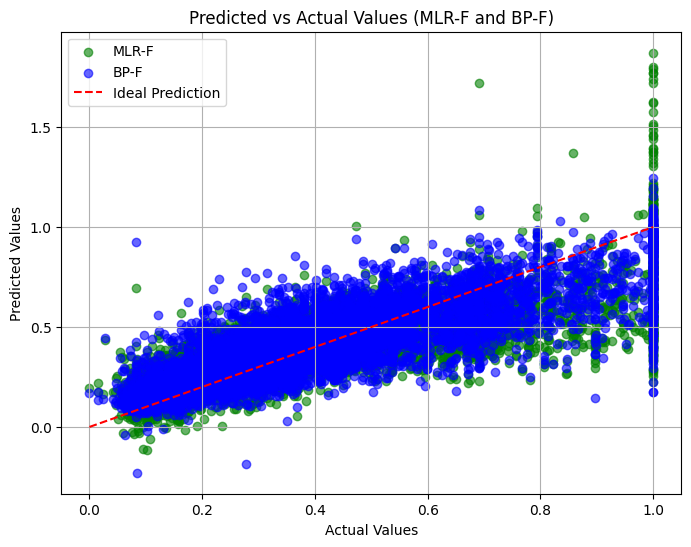

In [10]:
# Part 3.2: Model Result Comparison

# Extract the best result from Part 3.1
best_set = results_df.loc[results_df["MSE_Mean"].idxmin()]
best_hyperparameters = hyperparameter_sets[int(best_set["Set"]) - 1]
best_result = {
    "hyperparameters": best_hyperparameters,
    "metrics": {
        "MSE": best_set["MSE_Mean"],
        "MAE": best_set["MAE_Mean"],
        "MAPE": best_set["MAPE_Mean"]
    }
}
print("Best Hyperparameters from Part 3.1:", best_result["hyperparameters"])
print("Best Metrics from Part 3.1:", best_result["metrics"])

# Use best metrics directly from Part 3.1
mse_nn = best_result["metrics"]["MSE"]
mae_nn = best_result["metrics"]["MAE"]
mape_nn = best_result["metrics"]["MAPE"]

# --- Evaluate Multi-Linear Regression (MLR-F) ---
print("Evaluating Multi-Linear Regression (MLR-F)...")

# Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Log Transformation for Target
import numpy as np
y_train_log = np.log1p(y_train)  # Apply log transformation
y_val_log = np.log1p(y_val)

# Train MLR-F on Transformed Target
mlr_model = LinearRegression()
mlr_model.fit(X_train_scaled, y_train_log)
mlr_predictions_log = mlr_model.predict(X_val_scaled)

# Reverse Log Transformation for Predictions
mlr_predictions = np.expm1(mlr_predictions_log)

# Calculate Metrics for MLR-F
mse_mlr = mean_squared_error(y_val, mlr_predictions)
mae_mlr = mean_absolute_error(y_val, mlr_predictions)

# Adjusted MAPE (Excluding Near-Zero Values)
def adjusted_mape(y_true, y_pred):
    mask = y_true > 1e-10
    y_true, y_pred = y_true[mask], y_pred[mask]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_mlr = adjusted_mape(y_val, mlr_predictions)
print(f"MLR-F Results After Adjustment - MSE: {mse_mlr:.4f}, MAE: {mae_mlr:.4f}, MAPE: {mape_mlr:.4f}")

# --- Evaluate Pre-Built Neural Network (BP-F) ---
print("Evaluating Pre-Built Neural Network (BP-F)...")
bp_model = MLPRegressor(
    hidden_layer_sizes=best_hyperparameters["layers"][1:-1],  # Exclude input/output layers
    max_iter=200,
    random_state=42,
    activation="relu"  # Using ReLU for BP-F
)
bp_model.fit(X_train_scaled, y_train.ravel())
bp_predictions = bp_model.predict(X_val_scaled)

# Metrics for BP-F
mse_bp = mean_squared_error(y_val, bp_predictions)
mae_bp = mean_absolute_error(y_val, bp_predictions)
mape_bp = mean_absolute_percentage_error(y_val.ravel(), bp_predictions.ravel())
print(f"BP-F Results - MSE: {mse_bp:.4f}, MAE: {mae_bp:.4f}, MAPE: {mape_bp:.4f}")

# --- Create Comparison Table ---
comparison_df = pd.DataFrame({
    "Model": ["Custom NN (Best)", "MLR-F", "BP-F"],
    "MSE": [mse_nn, mse_mlr, mse_bp],
    "MAE": [mae_nn, mae_mlr, mae_bp],
    "MAPE": [mape_nn, mape_mlr, mape_bp]
})

print("\nComparison of Models:")
print(comparison_df)

# Scatter Plot for Predictions vs Actual Values (MLR-F and BP-F)
plt.figure(figsize=(8, 6))
plt.scatter(y_val, mlr_predictions, alpha=0.6, label="MLR-F", color="green")
plt.scatter(y_val, bp_predictions, alpha=0.6, label="BP-F", color="blue")
plt.plot(
    [y_val.min(), y_val.max()],
    [y_val.min(), y_val.max()],
    color="red",
    linestyle="--",
    label="Ideal Prediction"
)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values (MLR-F and BP-F)")
plt.legend()
plt.grid(True)
plt.show()
